#### IMPORTATION LIBRAIRIE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
os.environ['KERAS_BACKEND'] = 'torch'

import keras
import time
import datetime
import cv2
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
import random
from PIL import Image, ImageStat
from tqdm import tqdm

import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Importation de PyYAML
import yaml

# Importation de PyTorch
import torch
import torch.nn as nn
import torch.optim as optim


# os.environ["TF_KERAS"]='1'
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

Num CPUs Available:  1


#### EXPLORATION DATA ANALYSIS

In [2]:
# Fonction pour créer un log_dir unique par modèle
def get_log_dir(model_name):
    return f"logs/{model_name}/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [3]:
df_data = pd.read_csv(r'flipkart_com-ecommerce_sample_1050.csv')

In [4]:
df_data.head(5)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

In [5]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [6]:
df_data.describe()

retail_price  discounted_price
count    1049.000000       1049.000000
mean     2186.197331       1584.527169
std      7639.229411       7475.099680
min        35.000000         35.000000
25%       555.000000        340.000000
50%       999.000000        600.000000
75%      1999.000000       1199.000000
max    201000.000000     201000.000000

In [7]:
def extract_categories(category_tree):
    # Split the category tree string and get categories
    categories = category_tree.strip('[]').split(">>")
    
    # Extract top category
    top_category = categories[0].strip().replace('"', '')
    
    # Extract secondary category if available
    secondary_category = categories[1].strip().replace('"', '') if len(categories) > 1 else None
    
    # Extract tertiary category if available
    tertiary_category = categories[2].strip().replace('"', '') if len(categories) > 2 else None
    
    return top_category, secondary_category, tertiary_category

# Apply the function to each row in the DataFrame
df_data['top_category'], df_data['secondary_category'], df_data['tertiary_category'] = zip(*df_data['product_category_tree'].apply(extract_categories))

# Extract unique categories
unique_top_categories = df_data['top_category'].unique()
unique_secondary_categories = df_data['secondary_category'].unique()
unique_tertiary_categories = df_data['tertiary_category'].unique()

In [8]:
list_categ = df_data['top_category'].unique()
list_label = list_categ.tolist()
print(list_label)

['Home Furnishing', 'Baby Care', 'Watches', 'Home Decor & Festive Needs', 'Kitchen & Dining', 'Beauty and Personal Care', 'Computers']


In [9]:
df_data.image.isnull().sum()

0

In [10]:
df_data.image.duplicated().sum()

0

In [11]:
df_data.groupby('top_category')['image'].count()

top_category
Baby Care                     150
Beauty and Personal Care      150
Computers                     150
Home Decor & Festive Needs    150
Home Furnishing               150
Kitchen & Dining              150
Watches                       150
Name: image, dtype: int64

In [12]:
path_images = "./Images/train_images" 
list_photos = [file for file in listdir(path_images)]

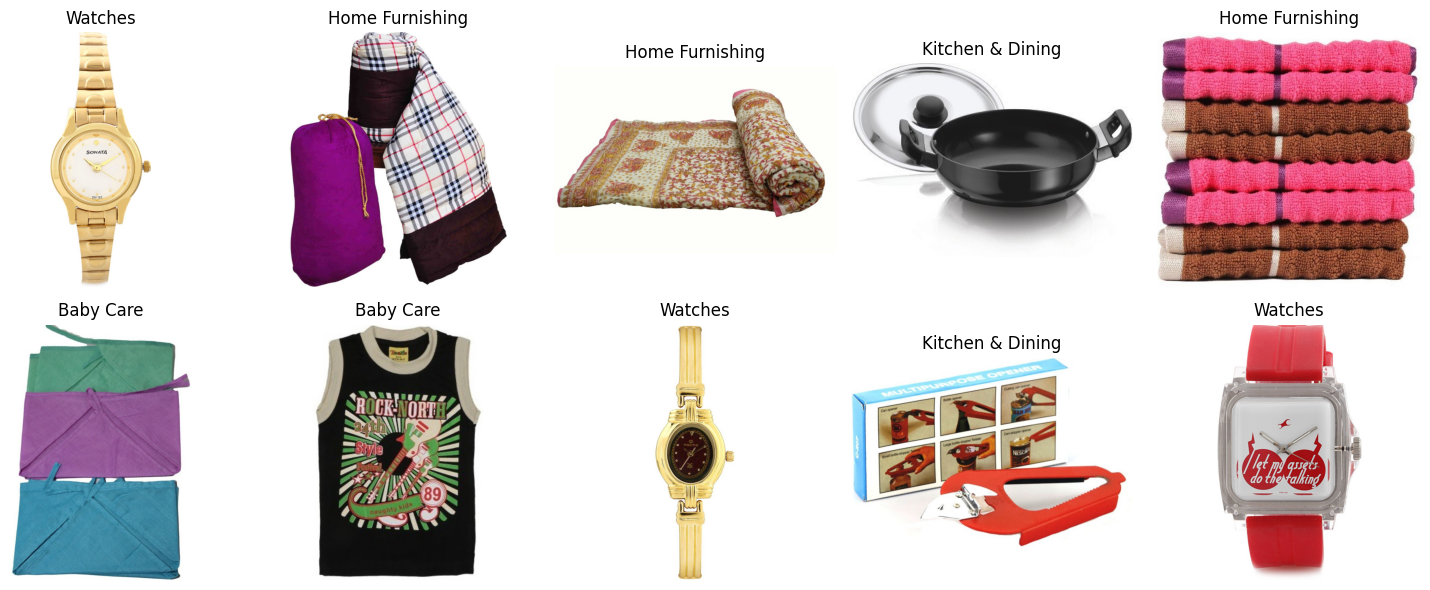

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(15,6))
for ax in axes.flat:
    random_file = random.choice(list_photos)
    img = Image.open(os.path.join(path_images, random_file))
    label = df_data[df_data['image'] == random_file]['top_category'].values[0]
    ax.imshow(img)
    ax.set_title(label)
    ax.axis("off")
plt.tight_layout()
plt.show()

Scan des images:   0%|          | 0/1050 [00:00<?, ?it/s]

Scan des images:  64%|██████▍   | 676/1050 [00:36<00:36, 10.31it/s]c:\Users\herbett\OneDrive - LEMKEN GmbH & Co.KG\Documents\Data_Science_OC\Classifier_automatiquement_biens_consommation\.venv\Lib\site-packages\PIL\Image.py:3452: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Scan des images: 100%|██████████| 1050/1050 [01:12<00:00, 14.58it/s]



Images lues avec succès : 1050 / Problèmes de lecture : 0


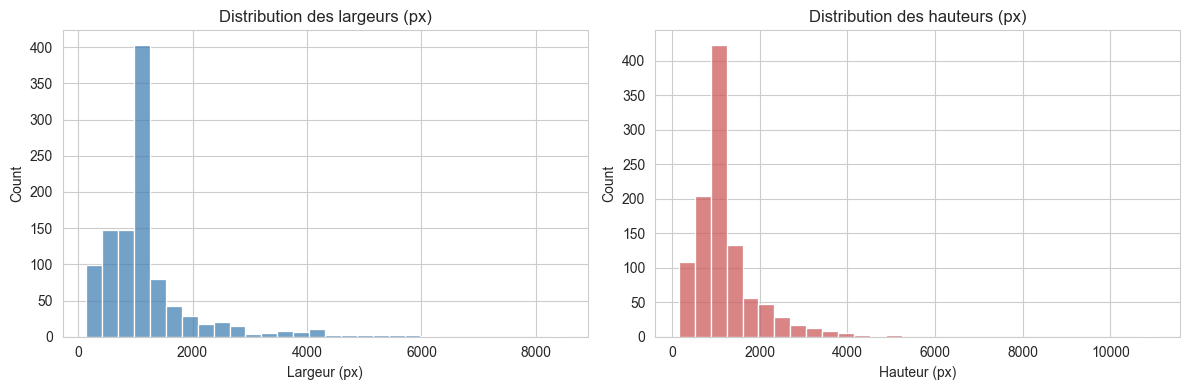

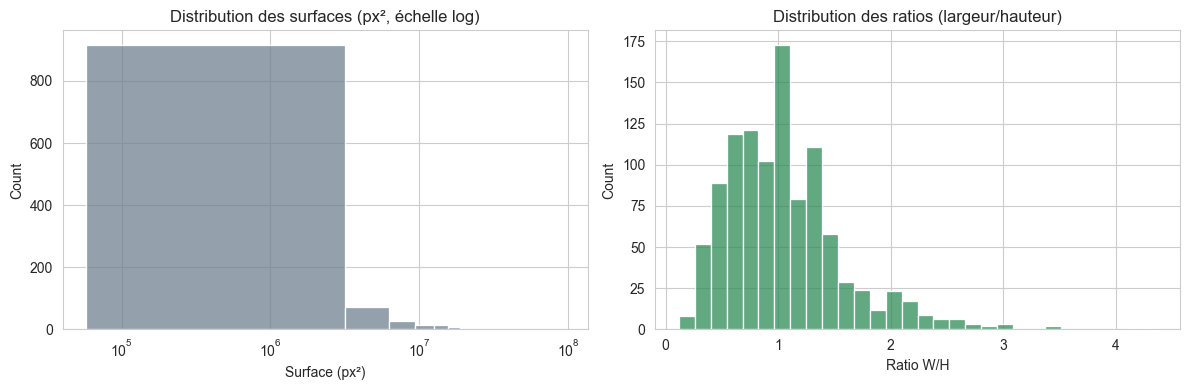

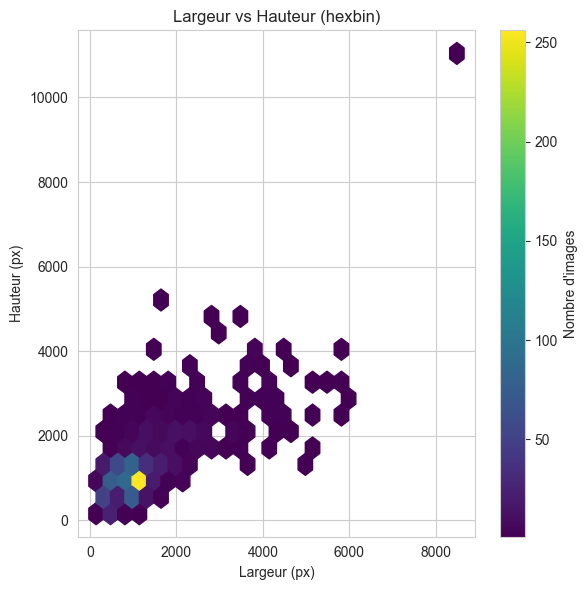

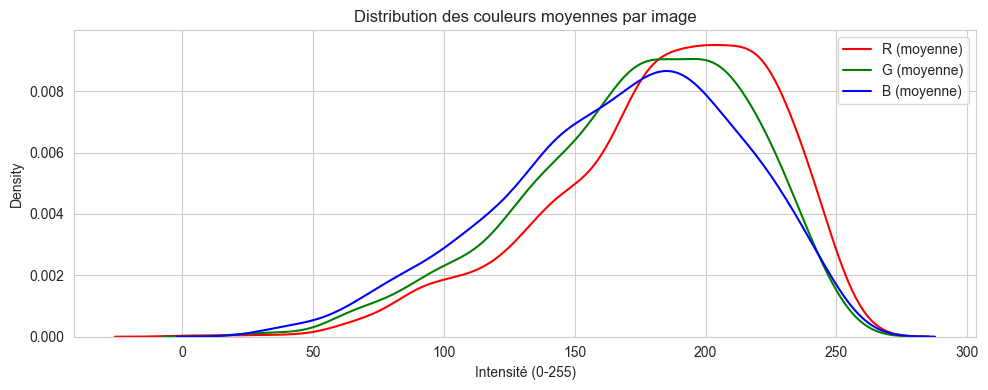

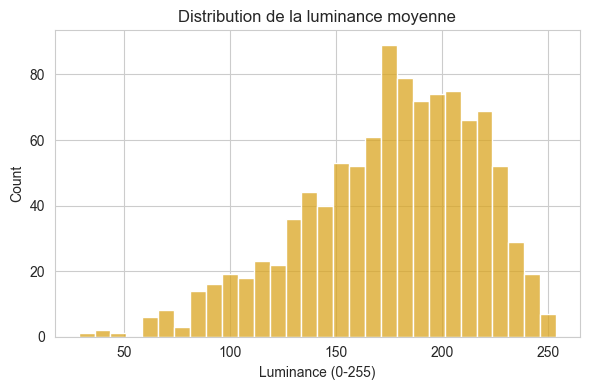

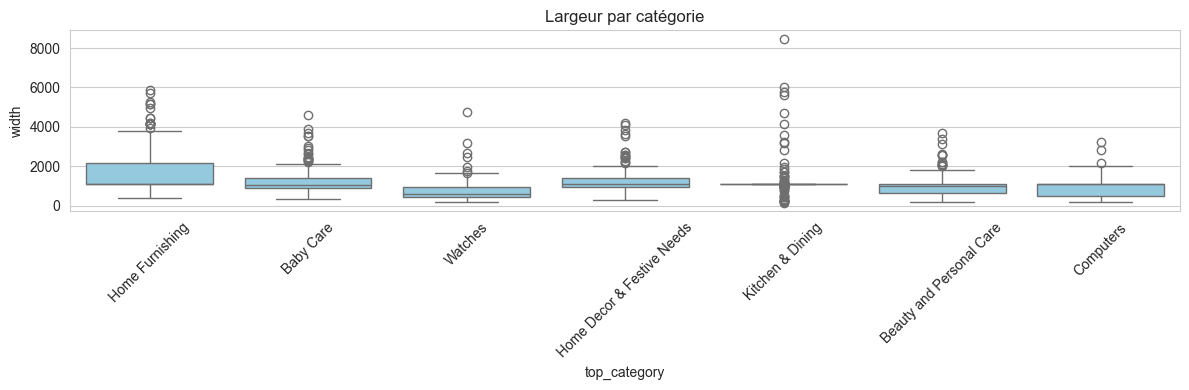

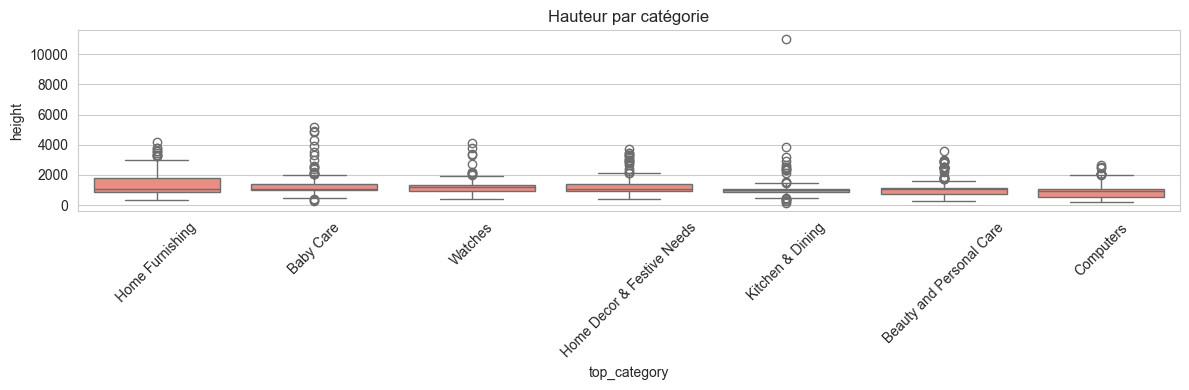

In [14]:
records = []
bad_files = []
for fname in tqdm(df_data['image'], desc="Scan des images"):
    fpath = os.path.join(path_images, fname)
    try:
        with Image.open(fpath) as im:
            # avant conversion : détecter si grayscale natif
            is_grayscale_native = im.mode in ('L','LA')
            im = im.convert('RGB')
            w, h = im.size
            area = w * h
            aspect = w / h if h != 0 else np.nan

            # Statistiques couleurs
            stat = ImageStat.Stat(im)   # mean/var par canal
            mean_r, mean_g, mean_b = stat.mean
            # Luminance (approx sRGB)
            luminance = 0.2126*mean_r + 0.7152*mean_g + 0.0722*mean_b

            records.append({
                'image': fname,
                'width': w, 'height': h, 'area': area, 'aspect_ratio': aspect,
                'mean_r': mean_r, 'mean_g': mean_g, 'mean_b': mean_b,
                'luminance': luminance,
                'is_grayscale_native': is_grayscale_native
            })
    except Exception as e:
        bad_files.append((fname, str(e)))

df_eda = pd.DataFrame(records).merge(
    df_data[['image','top_category']],
    on='image', how='left'
)

print(f"\nImages lues avec succès : {len(df_eda)} / Problèmes de lecture : {len(bad_files)}")
if bad_files:
    print("Exemples d’erreurs :", bad_files[:3])

# 3) Visualisations: Distribution des tailles
sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df_eda['width'].dropna(), bins=30, ax=axes[0], color='steelblue')
axes[0].set_title('Distribution des largeurs (px)')
axes[0].set_xlabel('Largeur (px)')

sns.histplot(df_eda['height'].dropna(), bins=30, ax=axes[1], color='indianred')
axes[1].set_title('Distribution des hauteurs (px)')
axes[1].set_xlabel('Hauteur (px)')
plt.tight_layout()
plt.show()

# surface (log-scale) & ratios d’aspect
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df_eda['area'].dropna(), bins=30, ax=axes[0], color='slategray')
axes[0].set_xscale('log')
axes[0].set_title('Distribution des surfaces (px², échelle log)')
axes[0].set_xlabel('Surface (px²)')

sns.histplot(df_eda['aspect_ratio'].dropna(), bins=30, ax=axes[1], color='seagreen')
axes[1].set_title('Distribution des ratios (largeur/hauteur)')
axes[1].set_xlabel('Ratio W/H')
plt.tight_layout()
plt.show()

# Nuage de points / heatmap de densité largeur vs hauteur
plt.figure(figsize=(6,6))
plt.hexbin(df_eda['width'], df_eda['height'], gridsize=25, cmap='viridis', mincnt=1)
plt.xlabel('Largeur (px)')
plt.ylabel('Hauteur (px)')
cb = plt.colorbar()
cb.set_label("Nombre d'images")
plt.title('Largeur vs Hauteur (hexbin)')
plt.tight_layout()
plt.show()

# 4) Distribution des couleurs (moyennes R/G/B + luminance)
plt.figure(figsize=(10,4))
sns.kdeplot(df_eda['mean_r'].dropna(), color='r', label='R (moyenne)')
sns.kdeplot(df_eda['mean_g'].dropna(), color='g', label='G (moyenne)')
sns.kdeplot(df_eda['mean_b'].dropna(), color='b', label='B (moyenne)')
plt.title('Distribution des couleurs moyennes par image')
plt.xlabel('Intensité (0-255)')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(df_eda['luminance'].dropna(), bins=30, color='goldenrod')
plt.title('Distribution de la luminance moyenne')
plt.xlabel('Luminance (0-255)')
plt.tight_layout()
plt.show()

# 5) Tailles par classe : boxplots rapides
plt.figure(figsize=(12,4))
sns.boxplot(data=df_eda, x='top_category', y='width', color='skyblue')
plt.title('Largeur par catégorie')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
sns.boxplot(data=df_eda, x='top_category', y='height', color='salmon')
plt.title('Hauteur par catégorie')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\herbett\AppData\Local\Temp\ipykernel_38036\3591187574.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_eda, x="top_category", y="luminance", palette="Set2")


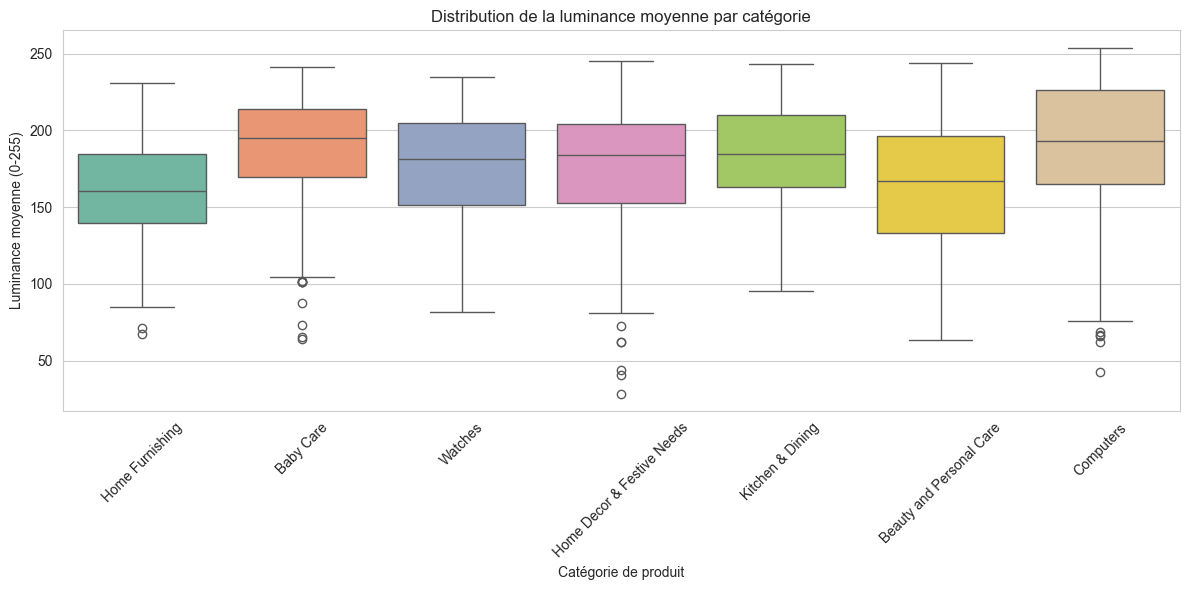

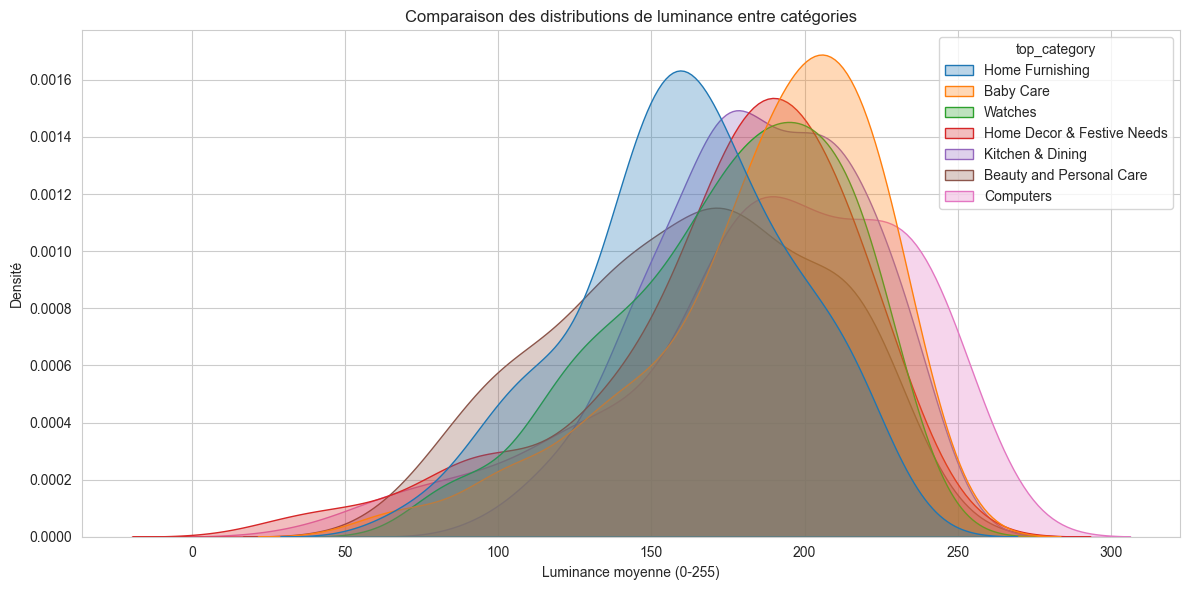

In [15]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_eda, x="top_category", y="luminance", palette="Set2")
plt.title("Distribution de la luminance moyenne par catégorie")
plt.xlabel("Catégorie de produit")
plt.ylabel("Luminance moyenne (0-255)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Version KDE (plus lisse, pour comparer les densités)
plt.figure(figsize=(12,6))
sns.kdeplot(data=df_eda, x="luminance", hue="top_category", fill=True, alpha=0.3)
plt.title("Comparaison des distributions de luminance entre catégories")
plt.xlabel("Luminance moyenne (0-255)")
plt.ylabel("Densité")
plt.tight_layout()
plt.show()

C:\Users\herbett\AppData\Local\Temp\ipykernel_38036\2833196490.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_eda, x="top_category", y="mean_r", palette="Reds")


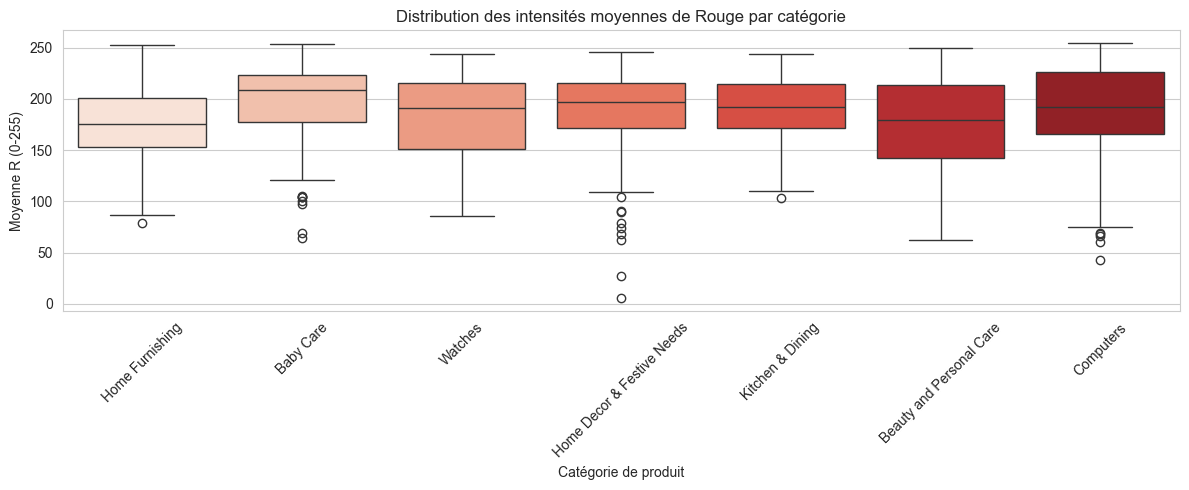

C:\Users\herbett\AppData\Local\Temp\ipykernel_38036\2833196490.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_eda, x="top_category", y="mean_g", palette="Greens")


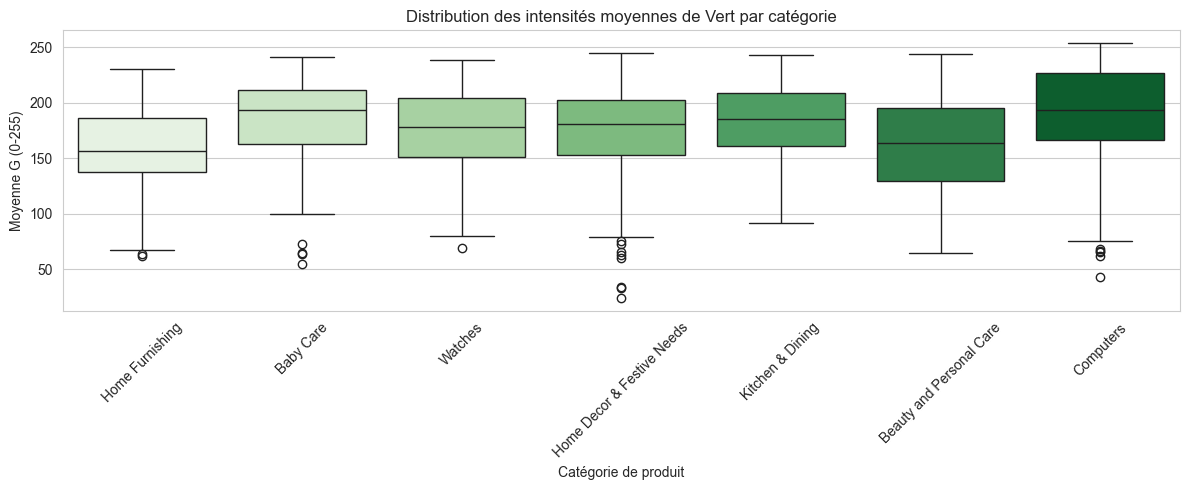

C:\Users\herbett\AppData\Local\Temp\ipykernel_38036\2833196490.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_eda, x="top_category", y="mean_b", palette="Blues")


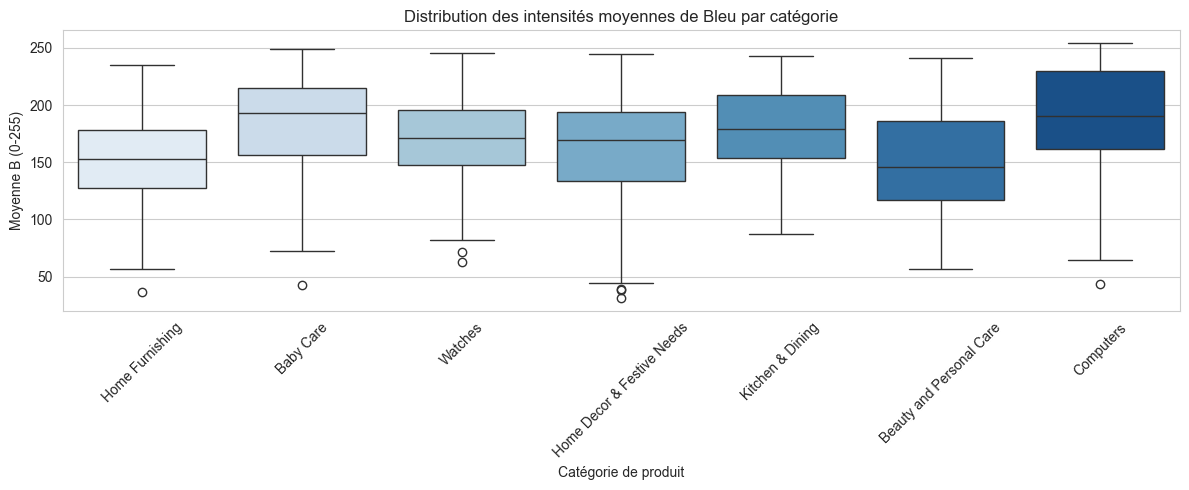

In [16]:
# Canal Rouge
plt.figure(figsize=(12,5))
sns.boxplot(data=df_eda, x="top_category", y="mean_r", palette="Reds")
plt.title("Distribution des intensités moyennes de Rouge par catégorie")
plt.xlabel("Catégorie de produit")
plt.ylabel("Moyenne R (0-255)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Canal Vert
plt.figure(figsize=(12,5))
sns.boxplot(data=df_eda, x="top_category", y="mean_g", palette="Greens")
plt.title("Distribution des intensités moyennes de Vert par catégorie")
plt.xlabel("Catégorie de produit")
plt.ylabel("Moyenne G (0-255)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Canal Bleu
plt.figure(figsize=(12,5))
sns.boxplot(data=df_eda, x="top_category", y="mean_b", palette="Blues")
plt.title("Distribution des intensités moyennes de Bleu par catégorie")
plt.xlabel("Catégorie de produit")
plt.ylabel("Moyenne B (0-255)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [17]:
# Chemins
input_dir = "./Images/train_images"   # dossier source
output_dir = "./Images_gray"           # dossier où on sauvegarde les images BW

# Création du dossier de sortie si inexistant
os.makedirs(output_dir, exist_ok=True)

# Paramètres
IMG_SIZE = (224, 224)

# Boucle sur les images
for fname in tqdm(os.listdir(input_dir)):
    if fname.lower().endswith((".jpg", ".png", ".jpeg")):
        fpath = os.path.join(input_dir, fname)
        try:
            # Ouverture de l'image
            with Image.open(fpath) as img:
                # Conversion en niveaux de gris (1 canal)
                img_gray = img.convert("L")  # 'L' = grayscale
                # Redimensionnement
                img_resized = img_gray.resize(IMG_SIZE)
                # Sauvegarde dans le nouveau dossier
                img_resized.save(os.path.join(output_dir, fname))
        except Exception as e:
            print(f"Erreur sur {fname} : {e}")

print("Toutes les images ont été converties en noir et blanc et redimensionnées.")

  0%|          | 0/1051 [00:00<?, ?it/s]

 32%|███▏      | 338/1051 [00:24<00:40, 17.43it/s]c:\Users\herbett\OneDrive - LEMKEN GmbH & Co.KG\Documents\Data_Science_OC\Classifier_automatiquement_biens_consommation\.venv\Lib\site-packages\PIL\Image.py:3452: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 1051/1051 [01:16<00:00, 13.79it/s]

Toutes les images ont été converties en noir et blanc et redimensionnées.


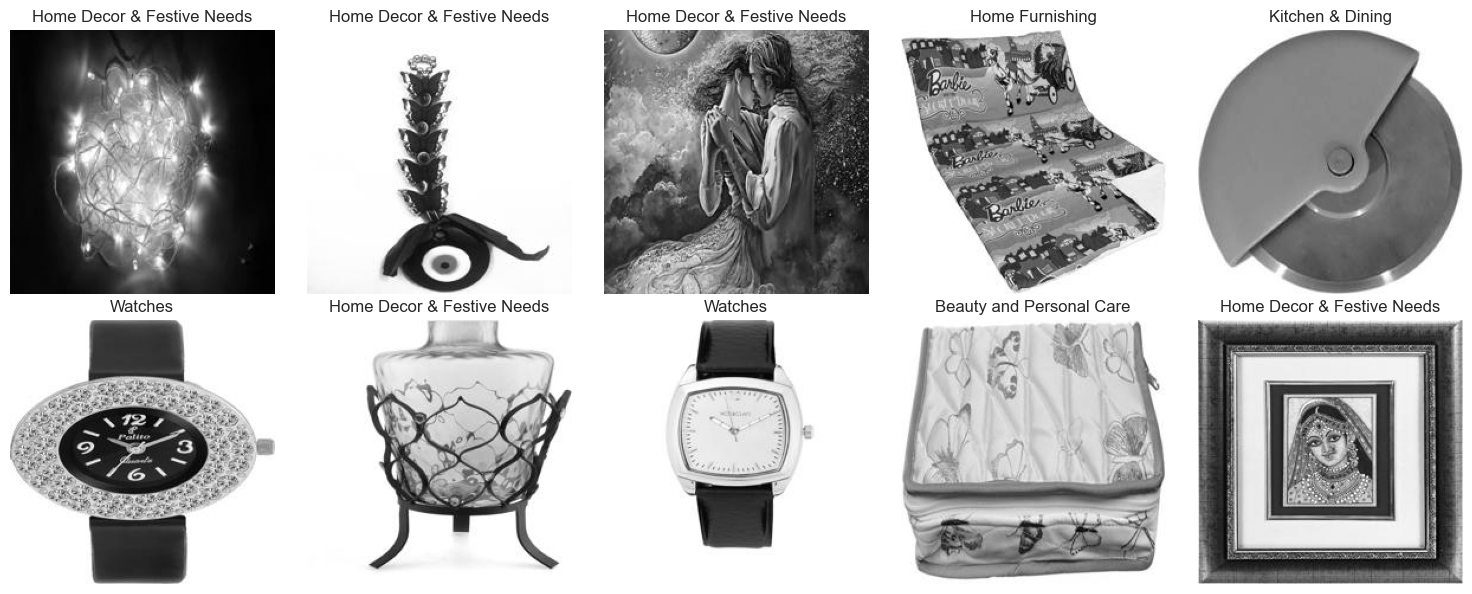

In [18]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for ax in axes.flat:
    random_file = random.choice(list_photos)
    img = Image.open(os.path.join(output_dir, random_file))
    
    # Récupérer le label correspondant depuis le DataFrame
    label = df_data[df_data['image'] == random_file]['top_category'].values[0]
    
    ax.imshow(img, cmap="gray")  # Important pour le gris
    ax.set_title(label)
    ax.axis("off")

plt.tight_layout()
plt.show()

#### SIFT

In [19]:
sift = cv2.SIFT_create()

keypoints_list = []
descriptors_list = []

for filename in os.listdir(output_dir):
    try:
        image_path = os.path.join(output_dir, filename)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            keypoints, descriptors = sift.detectAndCompute(img, None)
            keypoints_list.append(keypoints)
            descriptors_list.append(descriptors)
        else:
            print(f"Warning: Could not read image {image_path}")
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")

print(f"Processed {len(keypoints_list)} images.")

Processed 1050 images.


Image: 5df72b5295dc5e6126693e640b50f3a2.jpg
Nombre de keypoints: 39
Shape des descripteurs: (39, 128)


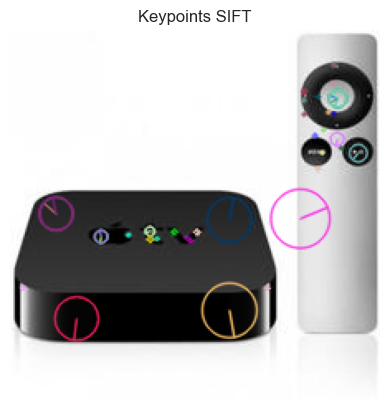

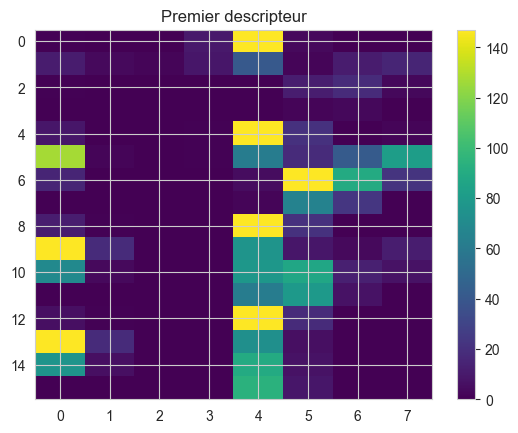

In [20]:
filename = "5df72b5295dc5e6126693e640b50f3a2.jpg"
image_path = os.path.join(output_dir, filename)

# lecture en niveaux de gris
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if img is None:
    print(f"Impossible de lire {filename}")
else:
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)

    print(f"Image: {filename}")
    print(f"Nombre de keypoints: {len(keypoints)}")
    print(f"Shape des descripteurs: {descriptors.shape}")  # (nb_points, 128)

    # Afficher keypoints
    img_with_kp = cv2.drawKeypoints(img, keypoints, None,
                                    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img_with_kp, cmap="gray")
    plt.title("Keypoints SIFT")
    plt.axis("off")
    plt.show()

    # Visualiser le premier descripteur
    first_descriptor = descriptors[0]
    plt.imshow(first_descriptor.reshape(16, 8), cmap="viridis", aspect="auto")
    plt.colorbar()
    plt.title("Premier descripteur")
    plt.show()

#### SIFT DATA AUGMENTATION

original: 39 keypoints, descriptors shape (39, 128)


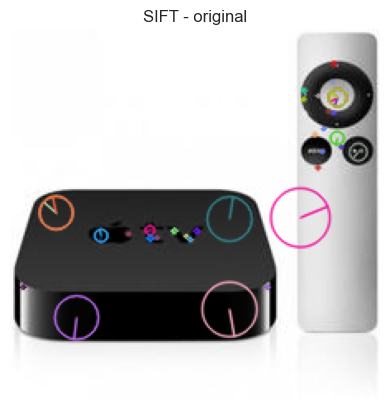

flipH: 37 keypoints, descriptors shape (37, 128)


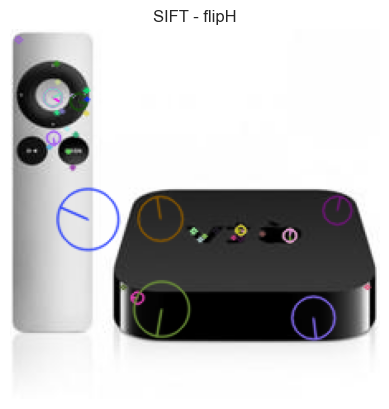

rot30: 42 keypoints, descriptors shape (42, 128)


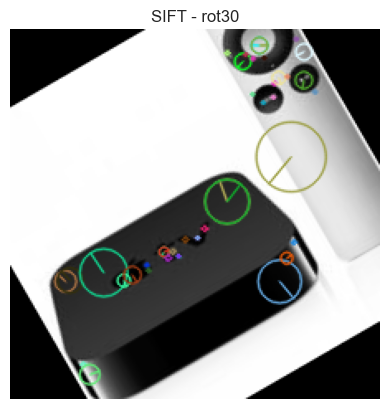

zoom: 25 keypoints, descriptors shape (25, 128)


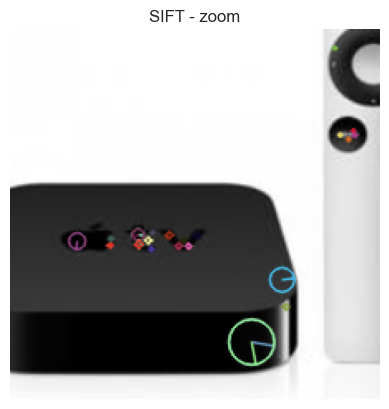

brighter: 39 keypoints, descriptors shape (39, 128)


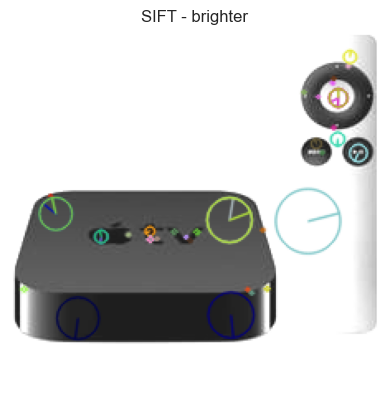

noisy: 204 keypoints, descriptors shape (204, 128)


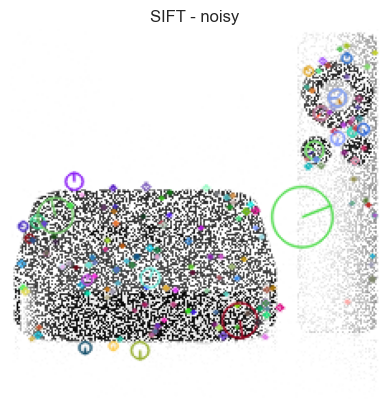

In [21]:
if img is None:
    print("Impossible de lire l'image")
else:
    sift = cv2.SIFT_create()
    augmented_images = {}
    
    # Data Augmentation
    augmented_images["original"] = img
    
    # Flip horizontal
    augmented_images["flipH"] = cv2.flip(img, 1)

    # Rotation 30°
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), 30, 1.0)
    augmented_images["rot30"] = cv2.warpAffine(img, M, (w, h))

    # Zoom
    scale = 0.8
    center_x, center_y = w // 2, h // 2
    new_w, new_h = int(w * scale), int(h * scale)
    cropped = img[center_y - new_h//2:center_y + new_h//2,
                  center_x - new_w//2:center_x + new_w//2]
    augmented_images["zoom"] = cv2.resize(cropped, (w, h))

    # Luminosité/contraste
    augmented_images["brighter"] = cv2.convertScaleAbs(img, alpha=1.2, beta=30)

    # Bruit gaussien
    noise = np.random.normal(0, 25, img.shape).astype(np.uint8)
    augmented_images["noisy"] = cv2.add(img, noise)

    # Passe chaque image dans SIFT
    descriptors_dict = {}
    for name, aug_img in augmented_images.items():
        gray = cv2.cvtColor(aug_img, cv2.IMREAD_GRAYSCALE)
        keypoints, descriptors = sift.detectAndCompute(gray, None)
        descriptors_dict[name] = descriptors
        print(f"{name}: {len(keypoints)} keypoints, descriptors shape {descriptors.shape if descriptors is not None else None}")

        # Visualisation rapide
        img_with_kp = cv2.drawKeypoints(gray, keypoints, None,
                                        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.figure()
        plt.imshow(img_with_kp, cmap="gray")
        plt.title(f"SIFT - {name}")
        plt.axis("off")
        plt.show()



#### CNN

In [22]:
df_gray = df_data[df_data['image'].isin(os.listdir(output_dir))].copy()

# 2) Split Train / Validation / Test
df_trainval, df_test = train_test_split(df_gray, test_size=0.15, stratify=df_gray['top_category'], random_state=42)
df_train, df_val = train_test_split(df_trainval, test_size=0.1765, stratify=df_trainval['top_category'], random_state=42)


print(f"Train: {len(df_train)}, Validation: {len(df_val)}, Test: {len(df_test)}")

# 3) Générateurs d'images
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

# Pour les images grayscale, on précise color_mode="grayscale"
base_train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

base_train_gen = base_train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=output_dir,
    x_col="image",
    y_col="top_category",
    target_size=IMG_SIZE,
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=output_dir,
    x_col="image",
    y_col="top_category",
    target_size=IMG_SIZE,
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=output_dir,
    x_col="image",
    y_col="top_category",
    target_size=IMG_SIZE,
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

Train: 734, Validation: 158, Test: 158
Found 734 validated image filenames belonging to 7 classes.
Found 158 validated image filenames belonging to 7 classes.
Found 158 validated image filenames belonging to 7 classes.


In [23]:
temps1 = time.time()
# 1) Construction du CNN
cnn_gray = Sequential([
    # Bloc 1
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,1)),
    MaxPooling2D((2,2)),
    
    # Bloc 2
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    # Bloc 3
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 classes
])

# 2) Compilation
cnn_gray.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_gray.summary()

# 3) Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('cnn_gray_best.h5', monitor='val_loss', save_best_only=True)

## Initialisation Tensorboard
#cnn_gray_log_dir = get_log_dir("cnn_gray")
#cnn_gray_tb_callback = tf.keras.callbacks.TensorBoard(log_dir=cnn_gray_log_dir)

# 4) Entraînement
history = cnn_gray.fit(
    base_train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stop, checkpoint] # si tensorboard souhaité alors changer le callback ici
)

# 5) Évaluation sur le test set
test_loss, test_acc = cnn_gray.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")
duration_cnn_gray = time.time()-temps1
print("temps de CNN : ", "%15.2f" % duration_cnn_gray, "secondes")

c:\Users\herbett\OneDrive - LEMKEN GmbH & Co.KG\Documents\Data_Science_OC\Classifier_automatiquement_biens_consommation\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,287 (42.61 MB)

 Trainable params: 11,169,287 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

c:\Users\herbett\OneDrive - LEMKEN GmbH & Co.KG\Documents\Data_Science_OC\Classifier_automatiquement_biens_consommation\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1377 - loss: 2.0942

46/46 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.1431 - loss: 1.9925 - val_accuracy: 0.2025 - val_loss: 1.9257
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2364 - loss: 1.8949

46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.2520 - loss: 1.8764 - val_accuracy: 0.3291 - val_loss: 1.8033
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4085 - loss: 1.6161

46/46 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.4414 - loss: 1.5476 - val_accuracy: 0.3987 - val_loss: 1.5479
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.5749 - loss: 1.2086 - val_accuracy: 0.4367 - val_loss: 1.5735
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.6798 - loss: 0.9186 - val_accuracy: 0.4620 - val_loss: 1.5926
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7916 - loss: 0.6300 - val_accuracy: 0.4747 - val_loss: 1.7553
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 478ms/step - accuracy: 0.3861 - loss: 1.6364
Test Accuracy: 0.3861, Test Loss: 1.6364
temps de CNN :           351.92 secondes


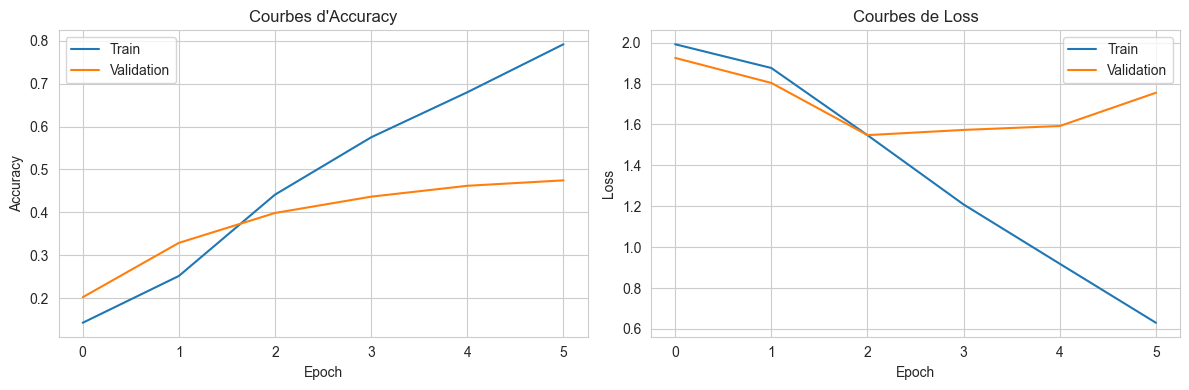

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step


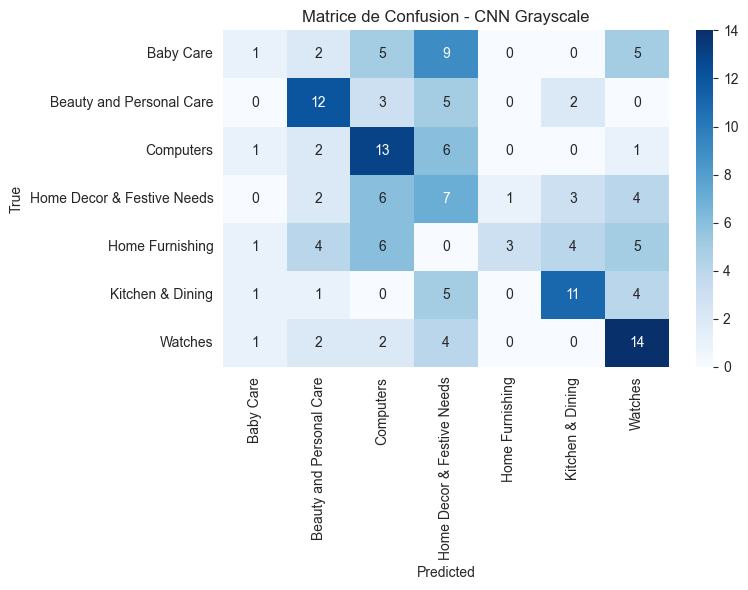

Classification Report
                            precision    recall  f1-score   support

                 Baby Care       0.20      0.05      0.07        22
  Beauty and Personal Care       0.48      0.55      0.51        22
                 Computers       0.37      0.57      0.45        23
Home Decor & Festive Needs       0.19      0.30      0.24        23
           Home Furnishing       0.75      0.13      0.22        23
          Kitchen & Dining       0.55      0.50      0.52        22
                   Watches       0.42      0.61      0.50        23

                  accuracy                           0.39       158
                 macro avg       0.42      0.39      0.36       158
              weighted avg       0.42      0.39      0.36       158



In [24]:
from sklearn.metrics import confusion_matrix, classification_report

# 1) Courbes d'accuracy et loss
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Courbes d'Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Courbes de Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# 2) Matrice de confusion
# Générer les prédictions sur le test set
y_pred_probs = cnn_gray.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes

# Noms des classes
class_names = list(test_gen.class_indices.keys())

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matrice de Confusion - CNN Grayscale")
plt.tight_layout()
plt.show()

# 3) Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report")
print(report)

In [25]:
#cnn_gray.save("cnn_gray_phase1.h5")

In [26]:
#from tensorflow.keras.models import load_model

#cnn_gray = load_model("cnn_gray_phase1.h5")

#### CNN - DATA AUGMENTATION

In [27]:
aug_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

aug_train_gen = aug_train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=output_dir,
    x_col="image",
    y_col="top_category",
    target_size=(224, 224),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=16,
    shuffle=True,
    seed=42
)


Found 734 validated image filenames belonging to 7 classes.


In [28]:
temps1 = time.time()

cnn_gray.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_aug = cnn_gray.fit(
    aug_train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stop, checkpoint]
)

# Réévaluation
test_loss_cnn_aug, test_acc_cnn_aug = cnn_gray.evaluate(test_gen)
print(f"Test Accuracy: {test_acc_cnn_aug:.4f}, Test Loss: {test_loss_cnn_aug:.4f}")
duration_cnn_aug = time.time()-temps1
print("Temps VGG16 : ", "%15.2f" % duration_cnn_aug, "secondes")

c:\Users\herbett\OneDrive - LEMKEN GmbH & Co.KG\Documents\Data_Science_OC\Classifier_automatiquement_biens_consommation\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.2943 - loss: 1.8560 - val_accuracy: 0.3291 - val_loss: 1.6614
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - accuracy: 0.3169 - loss: 1.7695

46/46 ━━━━━━━━━━━━━━━━━━━━ 45s 973ms/step - accuracy: 0.3106 - loss: 1.7463 - val_accuracy: 0.4937 - val_loss: 1.4992
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3652 - loss: 1.6383

46/46 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.3542 - loss: 1.6844 - val_accuracy: 0.4873 - val_loss: 1.4702
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3579 - loss: 1.6860

46/46 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.3692 - loss: 1.6775 - val_accuracy: 0.5380 - val_loss: 1.4347
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4111 - loss: 1.6291

46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.3992 - loss: 1.6103 - val_accuracy: 0.5000 - val_loss: 1.4188
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4051 - loss: 1.5678

46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.3883 - loss: 1.5922 - val_accuracy: 0.5506 - val_loss: 1.3679
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4631 - loss: 1.5298

46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.4482 - loss: 1.5361 - val_accuracy: 0.5190 - val_loss: 1.3636
Epoch 8/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4231 - loss: 1.5023

46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.4128 - loss: 1.5156 - val_accuracy: 0.4873 - val_loss: 1.3491
Epoch 9/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4217 - loss: 1.4323

46/46 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.4428 - loss: 1.4275 - val_accuracy: 0.5127 - val_loss: 1.3078
Epoch 10/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.4428 - loss: 1.4737 - val_accuracy: 0.5127 - val_loss: 1.3947
Epoch 11/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4492 - loss: 1.4367   

46/46 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.4523 - loss: 1.4350 - val_accuracy: 0.5253 - val_loss: 1.2801
Epoch 12/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4571 - loss: 1.4445

46/46 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.4646 - loss: 1.4064 - val_accuracy: 0.5063 - val_loss: 1.2422
Epoch 13/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.4755 - loss: 1.3651 - val_accuracy: 0.5253 - val_loss: 1.2601
Epoch 14/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4842 - loss: 1.3725

46/46 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.5068 - loss: 1.3568 - val_accuracy: 0.5506 - val_loss: 1.2293
Epoch 15/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.4946 - loss: 1.3244 - val_accuracy: 0.5127 - val_loss: 1.2703
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 582ms/step - accuracy: 0.5063 - loss: 1.4578
Test Accuracy: 0.5063, Test Loss: 1.4578
Temps VGG16 :           831.43 secondes


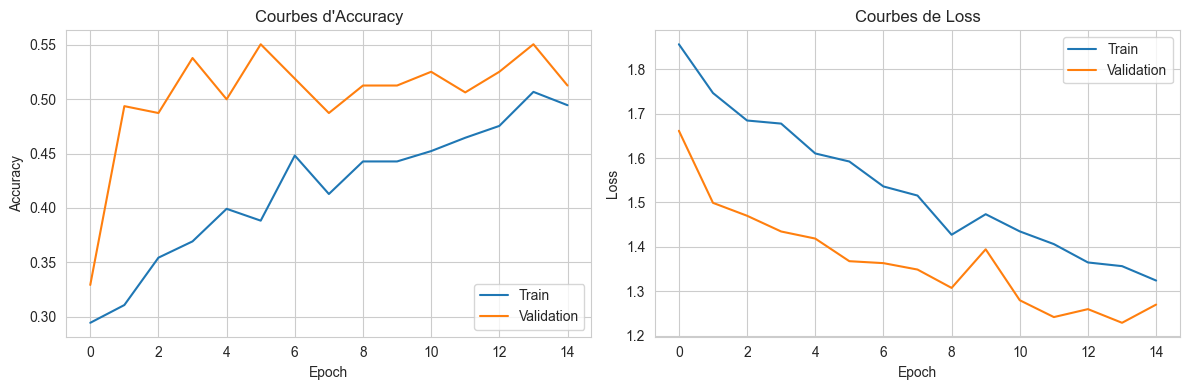

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 333ms/step


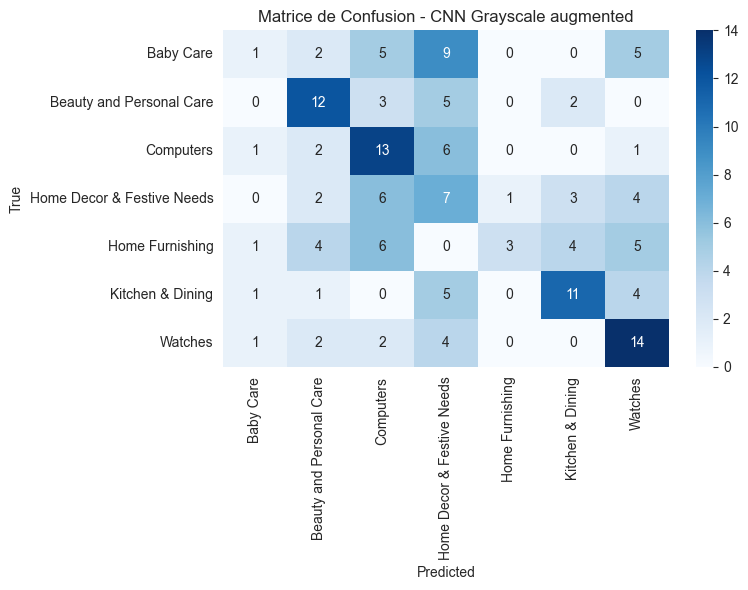

Classification Report
                            precision    recall  f1-score   support

                 Baby Care       0.43      0.41      0.42        22
  Beauty and Personal Care       0.54      0.59      0.57        22
                 Computers       0.55      0.48      0.51        23
Home Decor & Festive Needs       0.50      0.22      0.30        23
           Home Furnishing       0.55      0.48      0.51        23
          Kitchen & Dining       0.43      0.59      0.50        22
                   Watches       0.55      0.78      0.64        23

                  accuracy                           0.51       158
                 macro avg       0.51      0.51      0.49       158
              weighted avg       0.51      0.51      0.49       158



In [29]:
from sklearn.metrics import confusion_matrix, classification_report

# 1) Courbes d'accuracy et loss
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_aug.history['accuracy'], label='Train')
plt.plot(history_aug.history['val_accuracy'], label='Validation')
plt.title("Courbes d'Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_aug.history['loss'], label='Train')
plt.plot(history_aug.history['val_loss'], label='Validation')
plt.title("Courbes de Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# 2) Matrice de confusion
# Générer les prédictions sur le test set
y_pred_probs_cnn_aug = cnn_gray.predict(test_gen)
y_pred_cnn_aug = np.argmax(y_pred_probs_cnn_aug, axis=1)
y_true_cnn_aug = test_gen.classes

# Noms des classes
class_names = list(test_gen.class_indices.keys())

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matrice de Confusion - CNN Grayscale augmented")
plt.tight_layout()
plt.show()

# 3) Classification report
report = classification_report(y_true_cnn_aug, y_pred_cnn_aug, target_names=class_names)
print("Classification Report")
print(report)

#### CNN - Hyperparameter optimized

c:\Users\herbett\OneDrive - LEMKEN GmbH & Co.KG\Documents\Data_Science_OC\Classifier_automatiquement_biens_consommation\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,287 (42.61 MB)

 Trainable params: 11,169,287 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1434 - loss: 3.0215

46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.1689 - loss: 2.2696 - val_accuracy: 0.1456 - val_loss: 2.5682
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - accuracy: 0.2436 - loss: 1.9596

46/46 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.2943 - loss: 1.8223 - val_accuracy: 0.3861 - val_loss: 1.5939
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5042 - loss: 1.3849

46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.5068 - loss: 1.3986 - val_accuracy: 0.4557 - val_loss: 1.5091
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6881 - loss: 0.9531

46/46 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.6676 - loss: 0.9424 - val_accuracy: 0.4747 - val_loss: 1.4851
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 45s 987ms/step - accuracy: 0.7820 - loss: 0.6193 - val_accuracy: 0.4937 - val_loss: 1.8467
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.8760 - loss: 0.4061 - val_accuracy: 0.4810 - val_loss: 2.1114
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9114 - loss: 0.3191 - val_accuracy: 0.4747 - val_loss: 2.9407
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 284ms/step - accuracy: 0.4494 - loss: 1.7016
Test Accuracy: 0.4494, Test Loss: 1.7016
temps de CNN optimized :           354.67 secondes


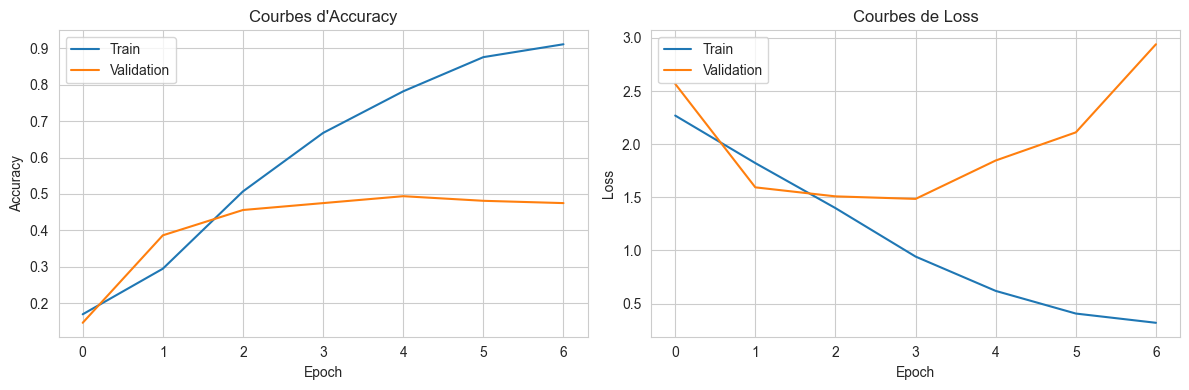

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 268ms/step


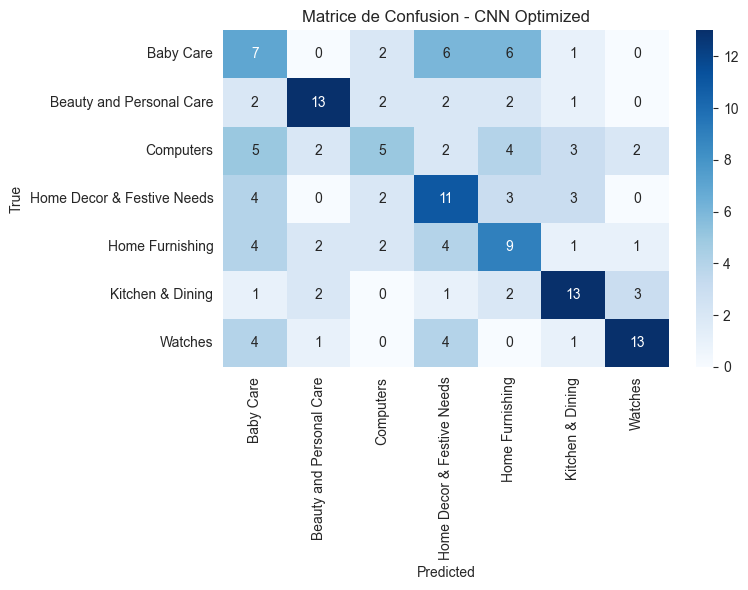

Classification Report
                            precision    recall  f1-score   support

                 Baby Care       0.26      0.32      0.29        22
  Beauty and Personal Care       0.65      0.59      0.62        22
                 Computers       0.38      0.22      0.28        23
Home Decor & Festive Needs       0.37      0.48      0.42        23
           Home Furnishing       0.35      0.39      0.37        23
          Kitchen & Dining       0.57      0.59      0.58        22
                   Watches       0.68      0.57      0.62        23

                  accuracy                           0.45       158
                 macro avg       0.47      0.45      0.45       158
              weighted avg       0.46      0.45      0.45       158



In [30]:
temps1 = time.time()

# 1) Construction du CNN
cnn_optimized = Sequential([
    # Bloc 1
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,1)),
    MaxPooling2D((2,2)),
    
    # Bloc 2
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    # Bloc 3
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')   # 7 classes
])

# 2) Compilation
cnn_optimized.compile(
    optimizer='rmsprop',             # CHNGEMENT:  optimizer
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_optimized.summary()

# 3) Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('cnn_optimized_best.h5', monitor='val_loss', save_best_only=True)

# 4) Entraînement
history = cnn_optimized.fit(
    base_train_gen,
    validation_data=val_gen,
    epochs=10,                       # CHANGEMENT: epochs = 10
    callbacks=[early_stop, checkpoint]
)

# 5) Évaluation sur le test set
test_loss_cnn_opt, test_acc_cnn_opt = cnn_optimized.evaluate(test_gen)
print(f"Test Accuracy: {test_acc_cnn_opt:.4f}, Test Loss: {test_loss_cnn_opt:.4f}")
duration_cnn_optimized = time.time()-temps1
print("temps de CNN optimized : ", "%15.2f" % duration_cnn_optimized, "secondes")

# 6) Analyses post-entraînement
from sklearn.metrics import confusion_matrix, classification_report

# Courbes d'accuracy et de loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Courbes d'Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Courbes de Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Matrice de confusion
y_pred_probs_cnn_optimized = cnn_optimized.predict(test_gen)
y_pred_cnn_optimized = np.argmax(y_pred_probs_cnn_optimized, axis=1)
y_true_cnn_otimized = test_gen.classes
class_names = list(test_gen.class_indices.keys())

cm = confusion_matrix(y_true_cnn_otimized, y_pred_cnn_optimized)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matrice de Confusion - CNN Optimized")
plt.tight_layout()
plt.show()

# 5) Classification report
report = classification_report(y_true_cnn_otimized, y_pred_cnn_optimized, target_names=class_names)
print("Classification Report")
print(report)

#### CNN Hyperparameter optimized with Data augmentation

In [31]:
temps1 = time.time()

cnn_optimized.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_aug = cnn_optimized.fit(
    aug_train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stop, checkpoint]
)

# Réévaluation
test_loss_cnn_opt_aug, test_acc_cnn_opt_aug = cnn_optimized.evaluate(test_gen)
print(f"Test Accuracy: {test_acc_cnn_opt_aug:.4f}, Test Loss: {test_loss_cnn_opt_aug:.4f}")
duration_cnn_opt_aug = time.time()-temps1
print("Temps VGG16 : ", "%15.2f" % duration_cnn_opt_aug, "secondes")

# Matrice de confusion
y_pred_probs_cnn_opt_aug = cnn_optimized.predict(test_gen)
y_pred_cnn_opt_aug = np.argmax(y_pred_probs_cnn_opt_aug, axis=1)
y_true_cnn_opt_aug = test_gen.classes
class_names = list(test_gen.class_indices.keys())

Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 947ms/step - accuracy: 0.2964 - loss: 1.8979

46/46 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.3106 - loss: 1.8045 - val_accuracy: 0.4430 - val_loss: 1.4451
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.3474 - loss: 1.7064 - val_accuracy: 0.4051 - val_loss: 1.4454
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4471 - loss: 1.5349

46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.4060 - loss: 1.5992 - val_accuracy: 0.4937 - val_loss: 1.3566
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.4183 - loss: 1.5743 - val_accuracy: 0.4937 - val_loss: 1.3858
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4209 - loss: 1.5393

46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.4183 - loss: 1.5385 - val_accuracy: 0.5443 - val_loss: 1.3352
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 984ms/step - accuracy: 0.4766 - loss: 1.4013

46/46 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.4564 - loss: 1.4282 - val_accuracy: 0.5063 - val_loss: 1.2753
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 44s 954ms/step - accuracy: 0.4782 - loss: 1.4280 - val_accuracy: 0.5316 - val_loss: 1.3482
Epoch 8/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 38s 819ms/step - accuracy: 0.5232 - loss: 1.4016 - val_accuracy: 0.5190 - val_loss: 1.2788
Epoch 9/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 40s 861ms/step - accuracy: 0.5054 - loss: 1.3753 - val_accuracy: 0.5380 - val_loss: 1.2955
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.5127 - loss: 1.4459
Test Accuracy: 0.5127, Test Loss: 1.4459
Temps VGG16 :           435.52 secondes
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step


#### VGG16

In [32]:
# === VGG16 TRANSFER LEARNING ===
from tensorflow.keras.applications import VGG16

temps1 = time.time()

# 1) Modèle VGG16 pré-entraîné
vgg16_base = VGG16(
    weights='imagenet',           # Poids pré-entraînés sur ImageNet
    include_top=False,            # Sans la couche de classification finale
    input_shape=(224, 224, 3)     # Format RGB
)

# Gel du modèle pré-entraîné
vgg16_base.trainable = False

# 2) Construction du modèle complet
vgg16_model = Sequential([
    vgg16_base,                           # Couches convolutionnelles pré-entraînées
    GlobalAveragePooling2D(),             # Remplace Flatten() pour éviter l'overfitting
    Dense(256, activation='relu'),        # Couche dense personnalisée
    Dropout(0.5),                         # Régularisation
    Dense(7, activation='softmax')        # 7 classes
])

# 3) Compilation
vgg16_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

vgg16_model.summary()

# 4) Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('vgg16_best.h5', monitor='val_loss', save_best_only=True)

# 5) Adaptation des générateurs pour RGB
# IMPORTANT: VGG16 attend des images RGB, pas grayscale

vgg_train_datagen = ImageDataGenerator(rescale=1./255)
vgg_val_datagen = ImageDataGenerator(rescale=1./255)
vgg_test_datagen = ImageDataGenerator(rescale=1./255)

vgg_train_gen = vgg_train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=output_dir,
    x_col="image",
    y_col="top_category",
    target_size=(224, 224),
    color_mode="rgb",              # rgb au lieu de grayscale
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

vgg_val_gen = vgg_val_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=output_dir,
    x_col="image",
    y_col="top_category",
    target_size=(224, 224),
    color_mode="rgb",              # rgb au lieu de grayscale
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

vgg_test_gen = vgg_test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=output_dir,
    x_col="image",
    y_col="top_category",
    target_size=(224, 224),
    color_mode="rgb",              # rgb au lieu de grayscale
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

# 6) Entraînement
history_vgg16 = vgg16_model.fit(
    vgg_train_gen,
    validation_data=vgg_val_gen,
    epochs=15,
    callbacks=[early_stop, checkpoint]
)

# 7) Évaluation sur le test set
test_loss_vgg16, test_acc_vgg16 = vgg16_model.evaluate(vgg_test_gen)
print(f"VGG16 - Test Accuracy: {test_acc_vgg16:.4f}, Test Loss: {test_loss_vgg16:.4f}")
duration_vgg16 = time.time()-temps1
print("Temps VGG16 : ", "%15.2f" % duration_vgg16, "secondes")

# 8) Optionnel: Fine-tuning
"""
# Dégel des dernières couches de VGG16
vgg16_base.trainable = True

# Gel des premières couches seulement
for layer in vgg16_base.layers[:-4]:
    layer.trainable = False

# Recompilation avec learning rate plus faible
vgg16_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # LR plus faible
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning
history_fine = vgg16_model.fit(
    vgg_train_gen,
    validation_data=vgg_val_gen,
    epochs=5,
    callbacks=[early_stop, checkpoint]
)
"""

print("VGG16 Transfer Learning terminé")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Found 734 validated image filenames belonging to 7 classes.
Found 158 validated image filenames belonging to 7 classes.
Found 158 validated image filenames belonging to 7 classes.


c:\Users\herbett\OneDrive - LEMKEN GmbH & Co.KG\Documents\Data_Science_OC\Classifier_automatiquement_biens_consommation\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2593 - loss: 1.9585

46/46 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - accuracy: 0.3610 - loss: 1.7289 - val_accuracy: 0.6203 - val_loss: 1.2827
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5774 - loss: 1.2443

46/46 ━━━━━━━━━━━━━━━━━━━━ 199s 4s/step - accuracy: 0.6117 - loss: 1.1934 - val_accuracy: 0.7025 - val_loss: 1.0339
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7067 - loss: 1.0036

46/46 ━━━━━━━━━━━━━━━━━━━━ 215s 5s/step - accuracy: 0.6798 - loss: 1.0083 - val_accuracy: 0.7342 - val_loss: 0.9375
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7048 - loss: 0.8980

46/46 ━━━━━━━━━━━━━━━━━━━━ 280s 6s/step - accuracy: 0.7003 - loss: 0.9219 - val_accuracy: 0.7405 - val_loss: 0.8876
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7190 - loss: 0.8078

46/46 ━━━━━━━━━━━━━━━━━━━━ 198s 4s/step - accuracy: 0.7289 - loss: 0.8380 - val_accuracy: 0.7405 - val_loss: 0.8195
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7663 - loss: 0.7734

46/46 ━━━━━━━━━━━━━━━━━━━━ 201s 4s/step - accuracy: 0.7548 - loss: 0.7937 - val_accuracy: 0.7658 - val_loss: 0.7977
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7567 - loss: 0.7450

46/46 ━━━━━━━━━━━━━━━━━━━━ 232s 5s/step - accuracy: 0.7657 - loss: 0.7371 - val_accuracy: 0.7595 - val_loss: 0.7856
Epoch 8/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7861 - loss: 0.6785

46/46 ━━━━━━━━━━━━━━━━━━━━ 251s 5s/step - accuracy: 0.7725 - loss: 0.7054 - val_accuracy: 0.7722 - val_loss: 0.7705
Epoch 9/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7695 - loss: 0.6911

46/46 ━━━━━━━━━━━━━━━━━━━━ 238s 5s/step - accuracy: 0.7902 - loss: 0.6481 - val_accuracy: 0.7658 - val_loss: 0.7599
Epoch 10/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7799 - loss: 0.6856

46/46 ━━━━━━━━━━━━━━━━━━━━ 257s 6s/step - accuracy: 0.8011 - loss: 0.6459 - val_accuracy: 0.7722 - val_loss: 0.7261
Epoch 11/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8232 - loss: 0.5758

46/46 ━━━━━━━━━━━━━━━━━━━━ 268s 6s/step - accuracy: 0.7956 - loss: 0.6103 - val_accuracy: 0.7911 - val_loss: 0.7167
Epoch 12/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8321 - loss: 0.5615

46/46 ━━━━━━━━━━━━━━━━━━━━ 246s 5s/step - accuracy: 0.8338 - loss: 0.5628 - val_accuracy: 0.7722 - val_loss: 0.7166
Epoch 13/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8203 - loss: 0.5278

46/46 ━━━━━━━━━━━━━━━━━━━━ 211s 5s/step - accuracy: 0.8202 - loss: 0.5505 - val_accuracy: 0.7785 - val_loss: 0.7076
Epoch 14/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8477 - loss: 0.4871

46/46 ━━━━━━━━━━━━━━━━━━━━ 207s 5s/step - accuracy: 0.8433 - loss: 0.5288 - val_accuracy: 0.7911 - val_loss: 0.6816
Epoch 15/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 205s 4s/step - accuracy: 0.8338 - loss: 0.5077 - val_accuracy: 0.7595 - val_loss: 0.7159
10/10 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.7468 - loss: 0.7369
VGG16 - Test Accuracy: 0.7468, Test Loss: 0.7369
Temps VGG16 :          3444.35 secondes
VGG16 Transfer Learning terminé


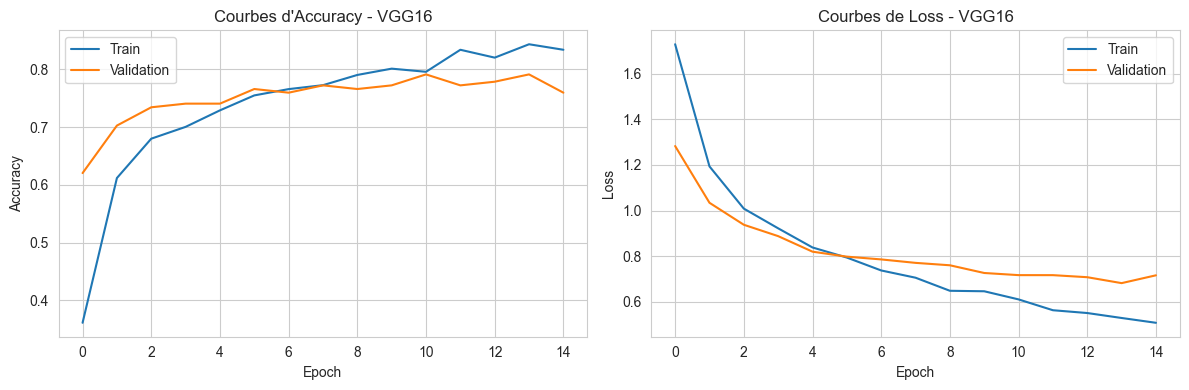

10/10 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step


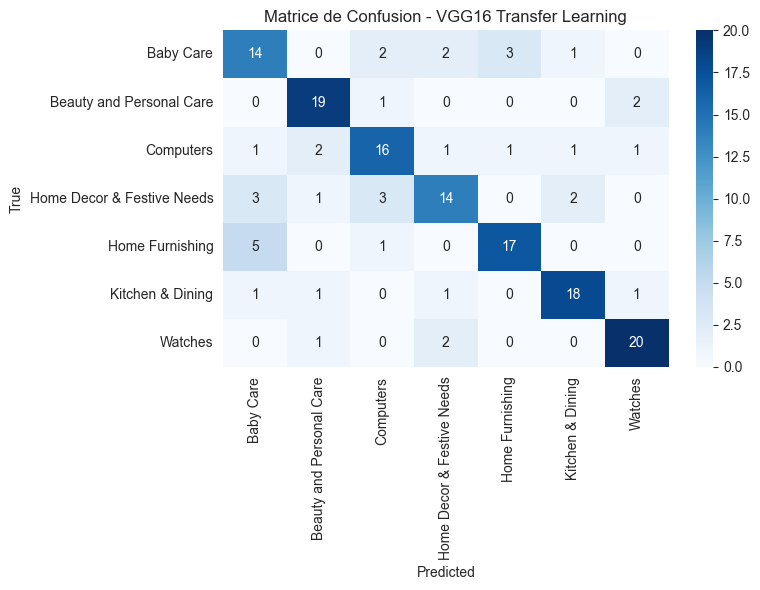

Classification Report VGG16
                            precision    recall  f1-score   support

                 Baby Care       0.58      0.64      0.61        22
  Beauty and Personal Care       0.79      0.86      0.83        22
                 Computers       0.70      0.70      0.70        23
Home Decor & Festive Needs       0.70      0.61      0.65        23
           Home Furnishing       0.81      0.74      0.77        23
          Kitchen & Dining       0.82      0.82      0.82        22
                   Watches       0.83      0.87      0.85        23

                  accuracy                           0.75       158
                 macro avg       0.75      0.75      0.75       158
              weighted avg       0.75      0.75      0.75       158


RÉSUMÉ - VGG16 Transfer Learning
Test Accuracy: 0.7468
Test Loss: 0.7369
Temps d'entraînement: 3444.35 secondes

Précision moyenne: 0.7477
Recall moyen: 0.7468
F1-score moyen: 0.7461


In [33]:
# 1) Courbes d'accuracy et loss
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_vgg16.history['accuracy'], label='Train')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation')
plt.title("Courbes d'Accuracy - VGG16")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_vgg16.history['loss'], label='Train')
plt.plot(history_vgg16.history['val_loss'], label='Validation')
plt.title("Courbes de Loss - VGG16")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# 2) Matrice de confusion
# Générer les prédictions sur le test set
y_pred_probs_vgg16 = vgg16_model.predict(vgg_test_gen)
y_pred_vgg16 = np.argmax(y_pred_probs_vgg16, axis=1)
y_true_vgg16 = vgg_test_gen.classes

# Noms des classes
class_names = list(vgg_test_gen.class_indices.keys())

# Matrice de confusion
cm_vgg16 = confusion_matrix(y_true_vgg16, y_pred_vgg16)

plt.figure(figsize=(8,6))
sns.heatmap(cm_vgg16, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matrice de Confusion - VGG16 Transfer Learning")
plt.tight_layout()
plt.show()

# 3) Classification report
report_vgg16 = classification_report(y_true_vgg16, y_pred_vgg16, target_names=class_names)
print("Classification Report VGG16")
print(report_vgg16)

# 4) Comparaison CNN vs VGG16
def compare_confusion_matrices(cm1, cm2, title1, title2, class_names):
    """Compare deux matrices de confusion côte à côte"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Matrice 1
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', 
               xticklabels=class_names, yticklabels=class_names, ax=ax1)
    ax1.set_xlabel("Predicted")
    ax1.set_ylabel("True")
    ax1.set_title(f"Matrice de Confusion - {title1}")
    
    # Matrice 2
    sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', 
               xticklabels=class_names, yticklabels=class_names, ax=ax2)
    ax2.set_xlabel("Predicted")
    ax2.set_ylabel("True")
    ax2.set_title(f"Matrice de Confusion - {title2}")
    
    plt.tight_layout()
    plt.show()

# Utilisation pour comparer
# compare_confusion_matrices(cm, cm_vgg16, "CNN Custom", "VGG16", class_names)

# 5) Résumé des performances
def print_model_summary(model_name, test_acc, test_loss, duration, y_true, y_pred, class_names):
    """Affiche un résumé des performances du modèle"""
    print(f"\n{'='*50}")
    print(f"RÉSUMÉ - {model_name}")
    print(f"{'='*50}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Temps d'entraînement: {duration:.2f} secondes")
    
    # Calcul de précision par classe
    report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    print(f"\nPrécision moyenne: {report_dict['weighted avg']['precision']:.4f}")
    print(f"Recall moyen: {report_dict['weighted avg']['recall']:.4f}")
    print(f"F1-score moyen: {report_dict['weighted avg']['f1-score']:.4f}")

# Utilisation
print_model_summary("VGG16 Transfer Learning", 
                   test_acc_vgg16, test_loss_vgg16, duration_vgg16,
                   y_true_vgg16, y_pred_vgg16, class_names)

#### VGG16 DATA AUGMENTATION

In [34]:
vgg16_aug_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

vgg16_aug_train_gen = vgg16_aug_train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=output_dir,
    x_col="image",
    y_col="top_category",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=16,
    shuffle=True,
    seed=42
)


Found 734 validated image filenames belonging to 7 classes.


In [35]:
temps1 = time.time()

# Générateurs validation et test (sans augmentation)
vgg_val_datagen = ImageDataGenerator(rescale=1./255)
vgg_test_datagen = ImageDataGenerator(rescale=1./255)

vgg_val_gen = vgg_val_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=output_dir,
    x_col="image",
    y_col="top_category",
    target_size=(224, 224),
    color_mode="rgb",          # rgb
    class_mode="categorical",
    batch_size=16,
    shuffle=True,
    seed=42
)

vgg_test_gen = vgg_test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=output_dir,
    x_col="image",
    y_col="top_category",
    target_size=(224, 224),
    color_mode="rgb",          # rgb
    class_mode="categorical",
    batch_size=16,
    shuffle=False
)

# 2) Modèle VGG16
vgg16_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)   # RGB
)

# Gel du modèle pré-entraîné
vgg16_base.trainable = False

# Modèle complet
vgg16_aug_model = Sequential([
    vgg16_base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

# 3) Compilation
vgg16_aug_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

vgg16_aug_model.summary()

# 4) Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('vgg16_augmented_best.h5', monitor='val_loss', save_best_only=True)

# 5) Entraînement avec données augmentées
print("Début de l'entraînement VGG16 avec Data Augmentation...")

history_vgg16_aug = vgg16_aug_model.fit(
    vgg16_aug_train_gen,# Générateur avec augmentation
    validation_data=vgg_val_gen,
    epochs=15,
    callbacks=[early_stop, checkpoint]
)

# 6) Évaluation
test_loss_vgg16_aug, test_acc_vgg16_aug = vgg16_aug_model.evaluate(vgg_test_gen)
print(f"VGG16 + Augmentation - Test Accuracy: {test_acc_vgg16_aug:.4f}, Test Loss: {test_loss_vgg16_aug:.4f}")
duration_vgg16_aug = time.time()-temps1
print("Temps VGG16 + Augmentation : ", "%15.2f" % duration_vgg16_aug, "secondes")


Found 158 validated image filenames belonging to 7 classes.


Found 158 validated image filenames belonging to 7 classes.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Début de l'entraînement VGG16 avec Data Augmentation...


c:\Users\herbett\OneDrive - LEMKEN GmbH & Co.KG\Documents\Data_Science_OC\Classifier_automatiquement_biens_consommation\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1976 - loss: 1.9881

46/46 ━━━━━━━━━━━━━━━━━━━━ 236s 5s/step - accuracy: 0.2725 - loss: 1.8410 - val_accuracy: 0.6456 - val_loss: 1.3983
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4775 - loss: 1.4947

46/46 ━━━━━━━━━━━━━━━━━━━━ 279s 6s/step - accuracy: 0.5218 - loss: 1.4080 - val_accuracy: 0.6962 - val_loss: 1.1165
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5965 - loss: 1.1996

46/46 ━━━━━━━━━━━━━━━━━━━━ 288s 6s/step - accuracy: 0.6035 - loss: 1.1929 - val_accuracy: 0.7089 - val_loss: 1.0005
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6335 - loss: 1.1285

46/46 ━━━━━━━━━━━━━━━━━━━━ 285s 6s/step - accuracy: 0.6362 - loss: 1.0947 - val_accuracy: 0.7278 - val_loss: 0.9080
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6303 - loss: 1.0621

46/46 ━━━━━━━━━━━━━━━━━━━━ 296s 6s/step - accuracy: 0.6540 - loss: 1.0392 - val_accuracy: 0.7089 - val_loss: 0.8786
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6948 - loss: 0.9501

46/46 ━━━━━━━━━━━━━━━━━━━━ 257s 6s/step - accuracy: 0.6880 - loss: 0.9573 - val_accuracy: 0.7595 - val_loss: 0.8547
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 258s 6s/step - accuracy: 0.6771 - loss: 0.9247 - val_accuracy: 0.7405 - val_loss: 0.8756
Epoch 8/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7406 - loss: 0.8350

46/46 ━━━━━━━━━━━━━━━━━━━━ 216s 5s/step - accuracy: 0.7166 - loss: 0.8857 - val_accuracy: 0.7532 - val_loss: 0.7978
Epoch 9/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7104 - loss: 0.8693

46/46 ━━━━━━━━━━━━━━━━━━━━ 211s 5s/step - accuracy: 0.7180 - loss: 0.8741 - val_accuracy: 0.7911 - val_loss: 0.7653
Epoch 10/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 211s 5s/step - accuracy: 0.7493 - loss: 0.7981 - val_accuracy: 0.7911 - val_loss: 0.7655
Epoch 11/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7326 - loss: 0.7971

46/46 ━━━━━━━━━━━━━━━━━━━━ 213s 5s/step - accuracy: 0.7330 - loss: 0.7810 - val_accuracy: 0.7658 - val_loss: 0.7484
Epoch 12/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7357 - loss: 0.7644

46/46 ━━━━━━━━━━━━━━━━━━━━ 215s 5s/step - accuracy: 0.7439 - loss: 0.7642 - val_accuracy: 0.7911 - val_loss: 0.7456
Epoch 13/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7670 - loss: 0.7403

46/46 ━━━━━━━━━━━━━━━━━━━━ 212s 5s/step - accuracy: 0.7684 - loss: 0.7446 - val_accuracy: 0.7911 - val_loss: 0.7237
Epoch 14/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 209s 5s/step - accuracy: 0.7480 - loss: 0.7349 - val_accuracy: 0.7848 - val_loss: 0.7281
Epoch 15/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 209s 5s/step - accuracy: 0.7711 - loss: 0.6876 - val_accuracy: 0.7722 - val_loss: 0.7276
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.7215 - loss: 0.7803
VGG16 + Augmentation - Test Accuracy: 0.7215, Test Loss: 0.7803
Temps VGG16 + Augmentation :          3631.61 secondes


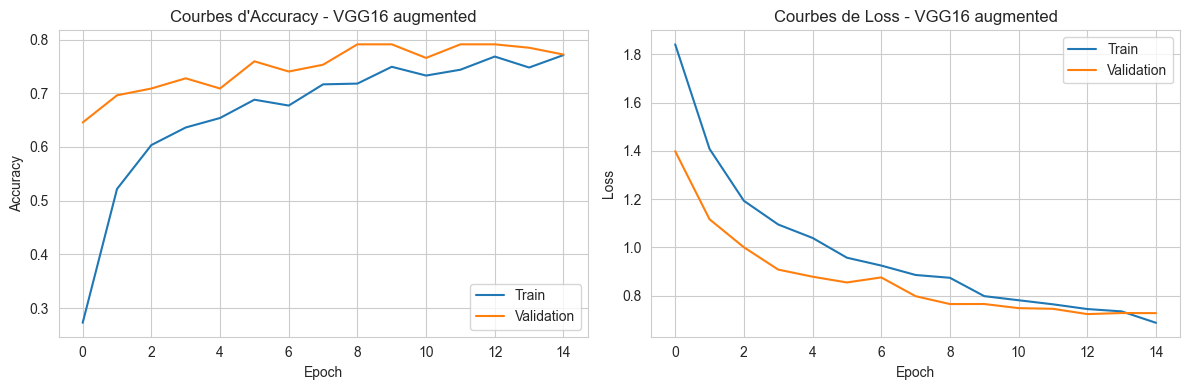

10/10 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step


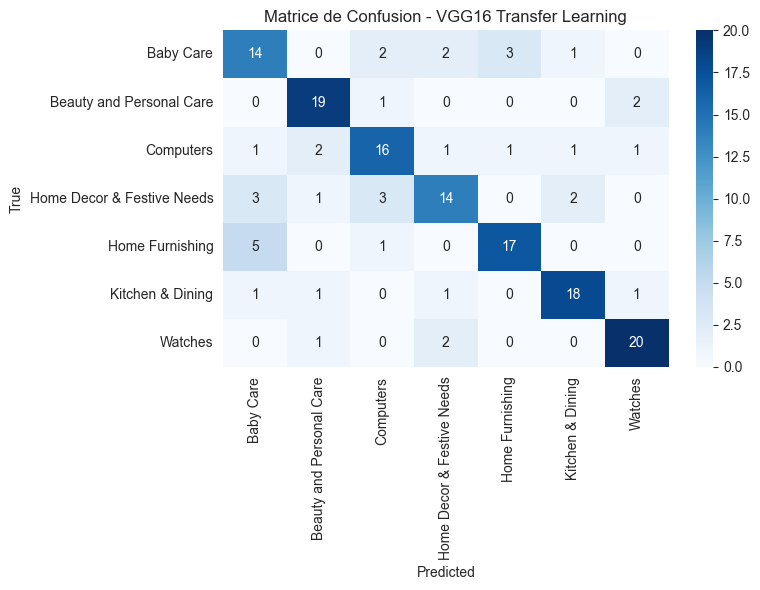

Classification Report VGG16
                            precision    recall  f1-score   support

                 Baby Care       0.58      0.64      0.61        22
  Beauty and Personal Care       0.79      0.86      0.83        22
                 Computers       0.70      0.70      0.70        23
Home Decor & Festive Needs       0.70      0.61      0.65        23
           Home Furnishing       0.81      0.74      0.77        23
          Kitchen & Dining       0.82      0.82      0.82        22
                   Watches       0.83      0.87      0.85        23

                  accuracy                           0.75       158
                 macro avg       0.75      0.75      0.75       158
              weighted avg       0.75      0.75      0.75       158


RÉSUMÉ - VGG16 Transfer Learning Data augmented
Test Accuracy: 0.7215
Test Loss: 0.7803
Temps d'entraînement: 3631.61 secondes

Précision moyenne: 0.7477
Recall moyen: 0.7468
F1-score moyen: 0.7461


In [36]:
# 1) Courbes d'accuracy et loss
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_vgg16_aug.history['accuracy'], label='Train')
plt.plot(history_vgg16_aug.history['val_accuracy'], label='Validation')
plt.title("Courbes d'Accuracy - VGG16 augmented")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_vgg16_aug.history['loss'], label='Train')
plt.plot(history_vgg16_aug.history['val_loss'], label='Validation')
plt.title("Courbes de Loss - VGG16 augmented")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# 2) Matrice de confusion
# Générer les prédictions sur le test set
y_pred_probs_vgg16_aug = vgg16_model.predict(vgg_test_gen)
y_pred_vgg16_aug = np.argmax(y_pred_probs_vgg16_aug, axis=1)
y_true_vgg16_aug = vgg_test_gen.classes

# Noms des classes
class_names = list(vgg_test_gen.class_indices.keys())

# Matrice de confusion
cm_vgg16 = confusion_matrix(y_true_vgg16_aug, y_pred_vgg16_aug)

plt.figure(figsize=(8,6))
sns.heatmap(cm_vgg16, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matrice de Confusion - VGG16 Transfer Learning")
plt.tight_layout()
plt.show()

# 3) Classification report
report_vgg16 = classification_report(y_true_vgg16_aug, y_pred_vgg16_aug, target_names=class_names)
print("Classification Report VGG16")
print(report_vgg16)

# 4) Comparaison CNN vs VGG16 (optionnel)

def compare_confusion_matrices(cm1, cm2, title1, title2, class_names):
    """Compare deux matrices de confusion côte à côte"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Matrice 1
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', 
               xticklabels=class_names, yticklabels=class_names, ax=ax1)
    ax1.set_xlabel("Predicted")
    ax1.set_ylabel("True")
    ax1.set_title(f"Matrice de Confusion - {title1}")
    
    # Matrice 2
    sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', 
               xticklabels=class_names, yticklabels=class_names, ax=ax2)
    ax2.set_xlabel("Predicted")
    ax2.set_ylabel("True")
    ax2.set_title(f"Matrice de Confusion - {title2}")
    
    plt.tight_layout()
    plt.show()

# Utilisation pour comparer
# compare_confusion_matrices(cm, cm_vgg16, "CNN Custom", "VGG16", class_names)

# Utilisation
print_model_summary("VGG16 Transfer Learning Data augmented", 
                   test_acc_vgg16_aug, test_loss_vgg16_aug, duration_vgg16_aug,
                   y_true_vgg16_aug, y_pred_vgg16_aug, class_names)

#### MOBILE NET V2

In [37]:
# MobileNetV2 TRANSFER LEARNING
from tensorflow.keras.applications import MobileNetV2

temps1 = time.time()

# 1) Modèle MobileNetV2 pré-entraîné
mobilenet_base = MobileNetV2(
    weights='imagenet',          # Poids pré-entraînés sur ImageNet
    include_top=False,           # Sans la couche fully connected finale
    input_shape=(224, 224, 3)    # Format RGB
)

# Gel du modèle pré-entraîné
mobilenet_base.trainable = False

# 2) Construction du modèle
mobilenet_model = Sequential([
    mobilenet_base,                        # Feature extractor
    GlobalAveragePooling2D(),              # Réduction dimensionnelle
    Dense(256, activation='relu'),         # Couche dense perso
    Dropout(0.5),                          # Régularisation
    Dense(7, activation='softmax')         # 7 classes
])

# 3) Compilation
mobilenet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mobilenet_model.summary()

# 4) Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('mobilenet_best.h5', monitor='val_loss', save_best_only=True)

# 5) Générateurs (MobileNetV2 attend aussi du RGB)
mobilenet_train_datagen = ImageDataGenerator(rescale=1./255)
mobilenet_val_datagen = ImageDataGenerator(rescale=1./255)
mobilenet_test_datagen = ImageDataGenerator(rescale=1./255)

mobilenet_train_gen = mobilenet_train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=output_dir,
    x_col="image",
    y_col="top_category",
    target_size=(224, 224),
    color_mode="rgb",                 # Changement: RGB obligatoire
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

mobilenet_val_gen = mobilenet_val_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=output_dir,
    x_col="image",
    y_col="top_category",
    target_size=(224, 224),
    color_mode="rgb",                 # RGB
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

mobilenet_test_gen = mobilenet_test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=output_dir,
    x_col="image",
    y_col="top_category",
    target_size=(224, 224),
    color_mode="rgb",                 # RGB
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

# 6) Entraînement
history_mobilenet = mobilenet_model.fit(
    mobilenet_train_gen,
    validation_data=mobilenet_val_gen,
    epochs=15,
    callbacks=[early_stop, checkpoint]
)

# 7) Évaluation sur le test set
test_loss_mobilenet, test_acc_mobilenet = mobilenet_model.evaluate(mobilenet_test_gen)
print(f"MobileNetV2 - Test Accuracy: {test_acc_mobilenet:.4f}, Test Loss: {test_loss_mobilenet:.4f}")
duration_mobilenet = time.time()-temps1
print("Temps MobileNetV2 : ", "%15.2f" % duration_mobilenet, "secondes")

# 8) Fine-tuning (optionnel)
"""
mobilenet_base.trainable = True

# On gèle seulement les premières couches (ex: sauf les 20 dernières)
for layer in mobilenet_base.layers[:-20]:
    layer.trainable = False

mobilenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # plus petit LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = mobilenet_model.fit(
    mobilenet_train_gen,
    validation_data=mobilenet_val_gen,
    epochs=5,
    callbacks=[early_stop, checkpoint]
)
"""

print("MobileNetV2 Transfer Learning terminé")


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,719 (9.87 MB)

 Trainable params: 329,735 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Found 734 validated image filenames belonging to 7 classes.
Found 158 validated image filenames belonging to 7 classes.
Found 158 validated image filenames belonging to 7 classes.


c:\Users\herbett\OneDrive - LEMKEN GmbH & Co.KG\Documents\Data_Science_OC\Classifier_automatiquement_biens_consommation\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.4520 - loss: 1.6835

46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 795ms/step - accuracy: 0.6144 - loss: 1.1903 - val_accuracy: 0.8101 - val_loss: 0.5729
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.8108 - loss: 0.5791

46/46 ━━━━━━━━━━━━━━━━━━━━ 35s 765ms/step - accuracy: 0.8365 - loss: 0.5093 - val_accuracy: 0.8228 - val_loss: 0.5248
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.8874 - loss: 0.3336

46/46 ━━━━━━━━━━━━━━━━━━━━ 35s 771ms/step - accuracy: 0.8692 - loss: 0.3675 - val_accuracy: 0.8418 - val_loss: 0.4811
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 34s 752ms/step - accuracy: 0.9142 - loss: 0.2642 - val_accuracy: 0.8418 - val_loss: 0.5021
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 35s 763ms/step - accuracy: 0.9387 - loss: 0.1864 - val_accuracy: 0.8228 - val_loss: 0.5223
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.9623 - loss: 0.1506

46/46 ━━━━━━━━━━━━━━━━━━━━ 36s 781ms/step - accuracy: 0.9659 - loss: 0.1364 - val_accuracy: 0.8481 - val_loss: 0.4568
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 36s 778ms/step - accuracy: 0.9850 - loss: 0.0765 - val_accuracy: 0.8544 - val_loss: 0.4938
Epoch 8/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 34s 750ms/step - accuracy: 0.9755 - loss: 0.0788 - val_accuracy: 0.8418 - val_loss: 0.4913
Epoch 9/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 34s 752ms/step - accuracy: 0.9755 - loss: 0.0739 - val_accuracy: 0.8354 - val_loss: 0.4910
Epoch 10/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 34s 750ms/step - accuracy: 0.9905 - loss: 0.0472 - val_accuracy: 0.8101 - val_loss: 0.5319
Epoch 11/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 34s 750ms/step - accuracy: 0.9918 - loss: 0.0450 - val_accuracy: 0.8165 - val_loss: 0.5694
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 628ms/step - accuracy: 0.8354 - loss: 0.5052
MobileNetV2 - Test Accuracy: 0.8354, Test Loss: 0.5052
Temps MobileNetV2 :           392.86 secondes
MobileNetV2 Transfer Learning terminé


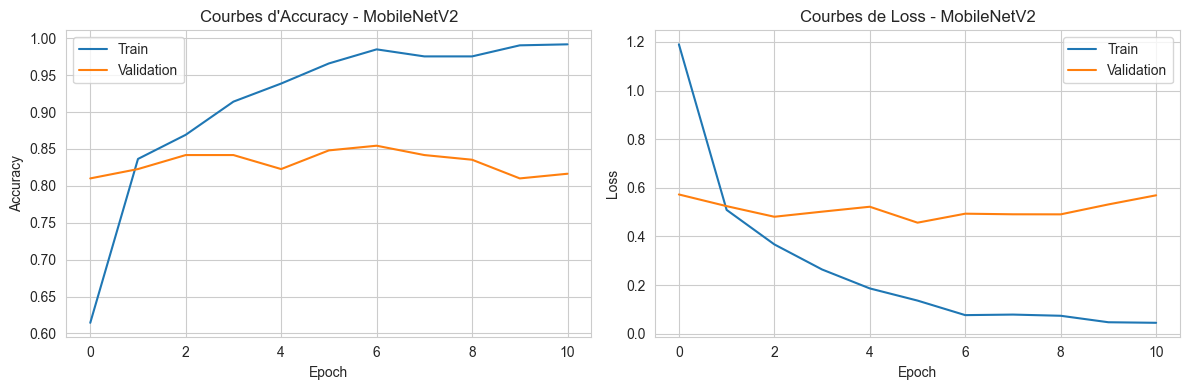

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 619ms/step


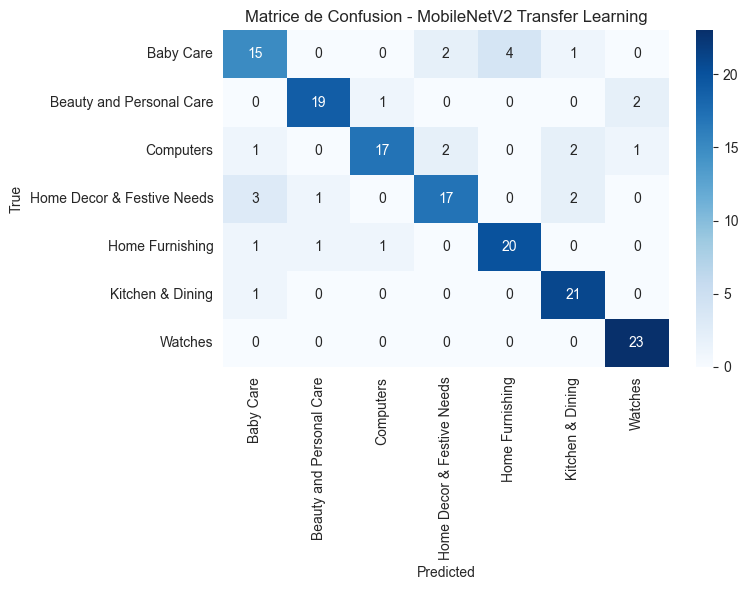

Classification Report MobileNetV2
                            precision    recall  f1-score   support

                 Baby Care       0.71      0.68      0.70        22
  Beauty and Personal Care       0.90      0.86      0.88        22
                 Computers       0.89      0.74      0.81        23
Home Decor & Festive Needs       0.81      0.74      0.77        23
           Home Furnishing       0.83      0.87      0.85        23
          Kitchen & Dining       0.81      0.95      0.88        22
                   Watches       0.88      1.00      0.94        23

                  accuracy                           0.84       158
                 macro avg       0.84      0.84      0.83       158
              weighted avg       0.84      0.84      0.83       158


RÉSUMÉ - MobileNetV2 Transfer Learning
Test Accuracy: 0.8354
Test Loss: 0.5052
Temps d'entraînement: 392.86 secondes

Précision moyenne: 0.8361
Recall moyen: 0.8354
F1-score moyen: 0.8329


In [38]:
# 1) Courbes d'accuracy et loss
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_mobilenet.history['accuracy'], label='Train')
plt.plot(history_mobilenet.history['val_accuracy'], label='Validation')
plt.title("Courbes d'Accuracy - MobileNetV2")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_mobilenet.history['loss'], label='Train')
plt.plot(history_mobilenet.history['val_loss'], label='Validation')
plt.title("Courbes de Loss - MobileNetV2")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# 2) Matrice de confusion
# Générer les prédictions sur le test set
y_pred_probs_mobilenet = mobilenet_model.predict(mobilenet_test_gen)
y_pred_mobilenet = np.argmax(y_pred_probs_mobilenet, axis=1)
y_true_mobilenet = mobilenet_test_gen.classes

# Noms des classes
class_names = list(mobilenet_test_gen.class_indices.keys())

# Matrice de confusion
cm_mobilenet = confusion_matrix(y_true_mobilenet, y_pred_mobilenet)

plt.figure(figsize=(8,6))
sns.heatmap(cm_mobilenet, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matrice de Confusion - MobileNetV2 Transfer Learning")
plt.tight_layout()
plt.show()

# 3) Classification report
report_mobilenet = classification_report(y_true_mobilenet, y_pred_mobilenet, target_names=class_names)
print("Classification Report MobileNetV2")
print(report_mobilenet)

# 4) Comparaison CNN vs MobileNetV2 (optionnel)
# compare_confusion_matrices(cm, cm_mobilenet, "CNN Custom", "MobileNetV2", class_names)

# 5) Résumé des performances
print_model_summary("MobileNetV2 Transfer Learning", 
                   test_acc_mobilenet, test_loss_mobilenet, duration_mobilenet,
                   y_true_mobilenet, y_pred_mobilenet, class_names)


#### MOBILE NET V2 AUGMENTATION

In [39]:
# 1) Data Augmentation pour MobileNetV2
mobilenet_aug_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

mobilenet_aug_train_gen = mobilenet_aug_train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=output_dir,
    x_col="image",
    y_col="top_category",
    target_size=(224, 224),
    color_mode="rgb",           # MobileNetV2 attend du RGB
    class_mode="categorical",
    batch_size=16,
    shuffle=True,
    seed=42
)

temps1 = time.time()

# 2) Générateurs validation et test (sans augmentation)
mobilenet_val_datagen = ImageDataGenerator(rescale=1./255)
mobilenet_test_datagen = ImageDataGenerator(rescale=1./255)

mobilenet_val_gen = mobilenet_val_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=output_dir,
    x_col="image",
    y_col="top_category",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=16,
    shuffle=True,
    seed=42
)

mobilenet_test_gen = mobilenet_test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=output_dir,
    x_col="image",
    y_col="top_category",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=16,
    shuffle=False
)

# 3) Modèle MobileNetV2
mobilenet_base = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)   # RGB
)

# Gel du modèle pré-entraîné
mobilenet_base.trainable = False

mobilenet_aug_model = Sequential([
    mobilenet_base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

# 4) Compilation
mobilenet_aug_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mobilenet_aug_model.summary()

# 5) Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('mobilenet_augmented_best.h5', monitor='val_loss', save_best_only=True)

# 6) Entraînement avec Data Augmentation
print("Début de l'entraînement MobileNetV2 avec Data Augmentation...")

history_mobilenet_aug = mobilenet_aug_model.fit(
    mobilenet_aug_train_gen,           # Générateur avec augmentation
    validation_data=mobilenet_val_gen,
    epochs=15,
    callbacks=[early_stop, checkpoint]
)

# 7) Évaluation
test_loss_mobilenet_aug, test_acc_mobilenet_aug = mobilenet_aug_model.evaluate(mobilenet_test_gen)
print(f"MobileNetV2 + Augmentation - Test Accuracy: {test_acc_mobilenet_aug:.4f}, Test Loss: {test_loss_mobilenet_aug:.4f}")
duration_mobilenet_aug = time.time()-temps1
print("Temps MobileNetV2 + Augmentation : ", "%15.2f" % duration_mobilenet_aug, "secondes")


Found 734 validated image filenames belonging to 7 classes.
Found 158 validated image filenames belonging to 7 classes.
Found 158 validated image filenames belonging to 7 classes.


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,719 (9.87 MB)

 Trainable params: 329,735 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Début de l'entraînement MobileNetV2 avec Data Augmentation...


c:\Users\herbett\OneDrive - LEMKEN GmbH & Co.KG\Documents\Data_Science_OC\Classifier_automatiquement_biens_consommation\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.4243 - loss: 1.6815

46/46 ━━━━━━━━━━━━━━━━━━━━ 45s 987ms/step - accuracy: 0.5790 - loss: 1.2895 - val_accuracy: 0.7848 - val_loss: 0.6198
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 844ms/step - accuracy: 0.7923 - loss: 0.6110

46/46 ━━━━━━━━━━━━━━━━━━━━ 45s 989ms/step - accuracy: 0.7834 - loss: 0.6231 - val_accuracy: 0.8228 - val_loss: 0.5265
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 846ms/step - accuracy: 0.8155 - loss: 0.5266

46/46 ━━━━━━━━━━━━━━━━━━━━ 46s 997ms/step - accuracy: 0.8215 - loss: 0.5234 - val_accuracy: 0.8228 - val_loss: 0.4960
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 854ms/step - accuracy: 0.8486 - loss: 0.4698

46/46 ━━━━━━━━━━━━━━━━━━━━ 46s 995ms/step - accuracy: 0.8529 - loss: 0.4528 - val_accuracy: 0.8291 - val_loss: 0.4910
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8951 - loss: 0.3383 - val_accuracy: 0.8291 - val_loss: 0.5579
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 846ms/step - accuracy: 0.8853 - loss: 0.3482

46/46 ━━━━━━━━━━━━━━━━━━━━ 45s 986ms/step - accuracy: 0.9005 - loss: 0.3187 - val_accuracy: 0.8418 - val_loss: 0.4908
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 45s 988ms/step - accuracy: 0.9005 - loss: 0.2809 - val_accuracy: 0.8481 - val_loss: 0.5080
Epoch 8/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 45s 986ms/step - accuracy: 0.9332 - loss: 0.2185 - val_accuracy: 0.8228 - val_loss: 0.5682
Epoch 9/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 45s 973ms/step - accuracy: 0.9346 - loss: 0.2172 - val_accuracy: 0.8354 - val_loss: 0.5440
Epoch 10/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 45s 980ms/step - accuracy: 0.9414 - loss: 0.1697 - val_accuracy: 0.8354 - val_loss: 0.5614
Epoch 11/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 45s 978ms/step - accuracy: 0.9537 - loss: 0.1365 - val_accuracy: 0.8481 - val_loss: 0.5323
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 600ms/step - accuracy: 0.8418 - loss: 0.5067
MobileNetV2 + Augmentation - Test Accuracy: 0.8418, Test Loss: 0.5067
Temps MobileNetV2 + Augmentation :           509.94 secondes


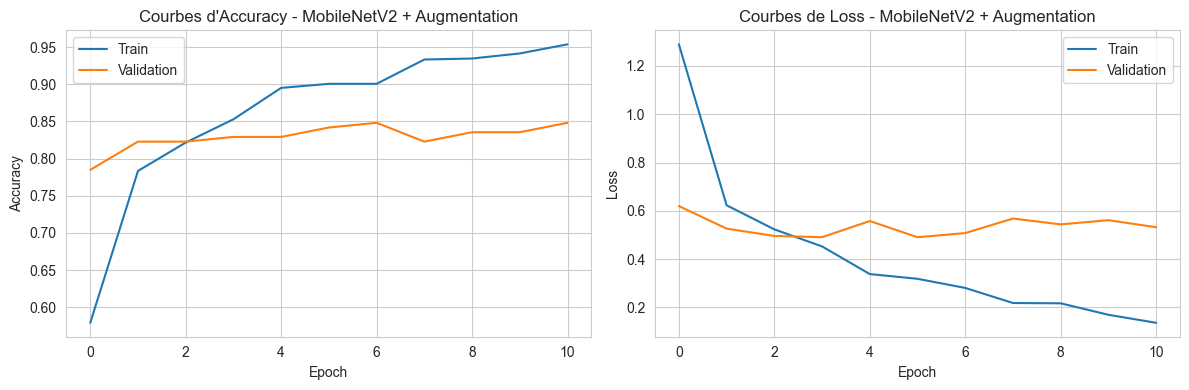

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 597ms/step


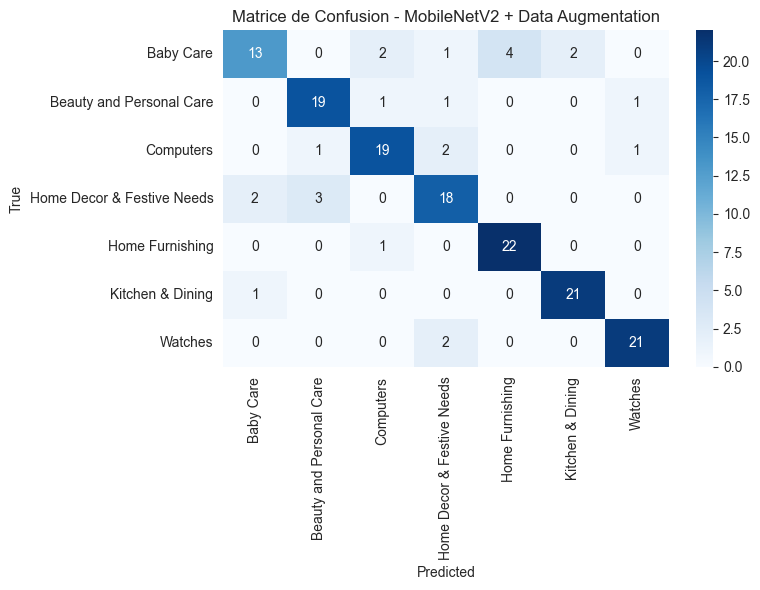

Classification Report MobileNetV2 + Augmentation
                            precision    recall  f1-score   support

                 Baby Care       0.81      0.59      0.68        22
  Beauty and Personal Care       0.83      0.86      0.84        22
                 Computers       0.83      0.83      0.83        23
Home Decor & Festive Needs       0.75      0.78      0.77        23
           Home Furnishing       0.85      0.96      0.90        23
          Kitchen & Dining       0.91      0.95      0.93        22
                   Watches       0.91      0.91      0.91        23

                  accuracy                           0.84       158
                 macro avg       0.84      0.84      0.84       158
              weighted avg       0.84      0.84      0.84       158


RÉSUMÉ - MobileNetV2 Transfer Learning + Data Augmentation
Test Accuracy: 0.8418
Test Loss: 0.5067
Temps d'entraînement: 509.94 secondes

Précision moyenne: 0.8408
Recall moyen: 0.8418
F1-score moyen

In [40]:
# 1) Courbes d'accuracy et loss
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_mobilenet_aug.history['accuracy'], label='Train')
plt.plot(history_mobilenet_aug.history['val_accuracy'], label='Validation')
plt.title("Courbes d'Accuracy - MobileNetV2 + Augmentation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_mobilenet_aug.history['loss'], label='Train')
plt.plot(history_mobilenet_aug.history['val_loss'], label='Validation')
plt.title("Courbes de Loss - MobileNetV2 + Augmentation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# 2) Matrice de confusion
# Générer les prédictions sur le test set
y_pred_probs_mobilenet_aug = mobilenet_aug_model.predict(mobilenet_test_gen)
y_pred_mobilenet_aug = np.argmax(y_pred_probs_mobilenet_aug, axis=1)
y_true_mobilenet_aug = mobilenet_test_gen.classes

# Noms des classes
class_names = list(mobilenet_test_gen.class_indices.keys())

# Matrice de confusion
cm_mobilenet_aug = confusion_matrix(y_true_mobilenet_aug, y_pred_mobilenet_aug)

plt.figure(figsize=(8,6))
sns.heatmap(cm_mobilenet_aug, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matrice de Confusion - MobileNetV2 + Data Augmentation")
plt.tight_layout()
plt.show()

# 3) Classification report
report_mobilenet_aug = classification_report(y_true_mobilenet_aug, y_pred_mobilenet_aug, target_names=class_names)
print("Classification Report MobileNetV2 + Augmentation")
print(report_mobilenet_aug)

# 4) Comparaison CNN vs MobileNetV2 Augmenté (optionnel)
# compare_confusion_matrices(cm, cm_mobilenet_aug, "CNN Custom", "MobileNetV2 + Augmentation", class_names)

# 5) Résumé des performances
print_model_summary("MobileNetV2 Transfer Learning + Data Augmentation", 
                   test_acc_mobilenet_aug, test_loss_mobilenet_aug, duration_mobilenet_aug,
                   y_true_mobilenet_aug, y_pred_mobilenet_aug, class_names)


#### RESNET 50

In [41]:
# RESNET50 TRANSFER LEARNING
from tensorflow.keras.applications import ResNet50

temps1 = time.time()

# 1) Modèle ResNet50 pré-entraîné
resnet_base = ResNet50(
    weights='imagenet',          # Poids pré-entraînés sur ImageNet
    include_top=False,           # Sans la couche fully connected finale
    input_shape=(224, 224, 3)    # Format RGB
)

# Gel du modèle pré-entraîné
resnet_base.trainable = False

# 2) Construction du modèle
resnet_model = Sequential([
    resnet_base,                        # Feature extractor
    GlobalAveragePooling2D(),           # Réduction dimensionnelle
    Dense(256, activation='relu'),      # Couche dense perso
    Dropout(0.5),                       # Régularisation
    Dense(7, activation='softmax')      # 7 classes
])

# 3) Compilation
resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

resnet_model.summary()

# 4) Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('resnet50_best.h5', monitor='val_loss', save_best_only=True)

# 5) Générateurs
# ResNet50 attend du RGB, mais avec une normalisation différente
# (prétraitement ResNet = centré autour de zéro avec preprocessing_function)
from tensorflow.keras.applications.resnet50 import preprocess_input

resnet_train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
resnet_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
resnet_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

resnet_train_gen = resnet_train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=output_dir,
    x_col="image",
    y_col="top_category",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

resnet_val_gen = resnet_val_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=output_dir,
    x_col="image",
    y_col="top_category",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

resnet_test_gen = resnet_test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=output_dir,
    x_col="image",
    y_col="top_category",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

# 6) Entraînement
history_resnet = resnet_model.fit(
    resnet_train_gen,
    validation_data=resnet_val_gen,
    epochs=15,
    callbacks=[early_stop, checkpoint]
)

# 7) Évaluation sur le test set
test_loss_resnet, test_acc_resnet = resnet_model.evaluate(resnet_test_gen)
print(f"ResNet50 - Test Accuracy: {test_acc_resnet:.4f}, Test Loss: {test_loss_resnet:.4f}")
duration_resnet = time.time()-temps1
print("Temps ResNet50 : ", "%15.2f" % duration_resnet, "secondes")

# 8) Fine-tuning (optionnel)
"""
resnet_base.trainable = True

# On gèle seulement les premières couches (ex: sauf les 30 dernières)
for layer in resnet_base.layers[:-30]:
    layer.trainable = False

resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = resnet_model.fit(
    resnet_train_gen,
    validation_data=resnet_val_gen,
    epochs=5,
    callbacks=[early_stop, checkpoint]
)
"""

print("ResNet50 Transfer Learning terminé")


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,114,055 (91.99 MB)

 Trainable params: 526,343 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Found 734 validated image filenames belonging to 7 classes.
Found 158 validated image filenames belonging to 7 classes.
Found 158 validated image filenames belonging to 7 classes.


c:\Users\herbett\OneDrive - LEMKEN GmbH & Co.KG\Documents\Data_Science_OC\Classifier_automatiquement_biens_consommation\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4079 - loss: 1.9540

46/46 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.5913 - loss: 1.2797 - val_accuracy: 0.7658 - val_loss: 0.6632
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8295 - loss: 0.5301

46/46 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.8283 - loss: 0.5403 - val_accuracy: 0.7848 - val_loss: 0.6343
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8599 - loss: 0.4310

46/46 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.8651 - loss: 0.3814 - val_accuracy: 0.8165 - val_loss: 0.5806
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9143 - loss: 0.2707

46/46 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.9169 - loss: 0.2466 - val_accuracy: 0.8354 - val_loss: 0.5805
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.9441 - loss: 0.2026 - val_accuracy: 0.7911 - val_loss: 0.6106
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.9605 - loss: 0.1513 - val_accuracy: 0.8165 - val_loss: 0.6463
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.9537 - loss: 0.1291 - val_accuracy: 0.7911 - val_loss: 0.7091
Epoch 8/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.9714 - loss: 0.0982 - val_accuracy: 0.8101 - val_loss: 0.7302
Epoch 9/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.9768 - loss: 0.0826 - val_accuracy: 0.8038 - val_loss: 0.7476
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8354 - loss: 0.5409
ResNet50 - Test Accuracy: 0.8354, Test Loss: 0.5409
Temps ResNet50 :          1062.72 secondes
ResNet50 Transfer Learning terminé


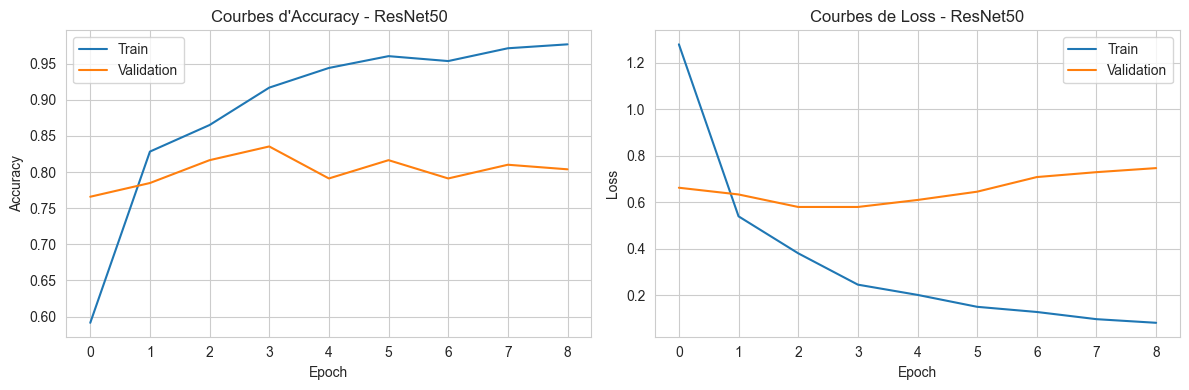

10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step


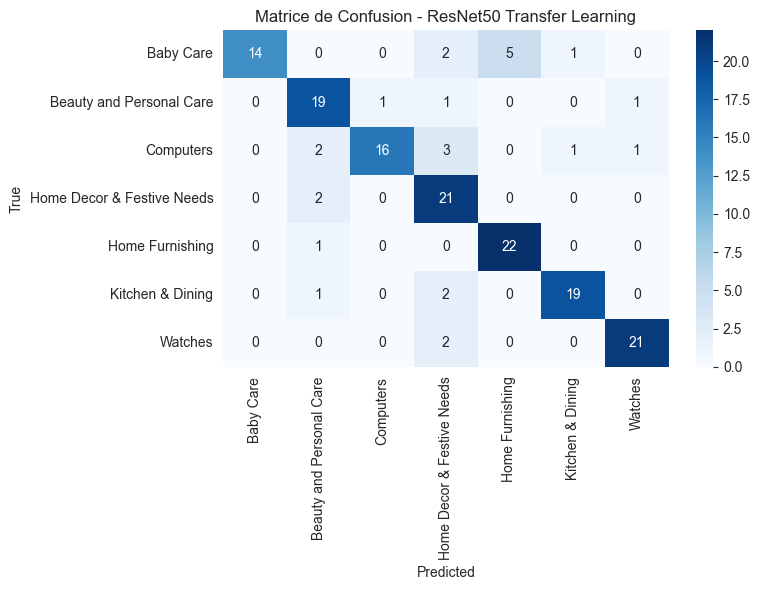

Classification Report ResNet50
                            precision    recall  f1-score   support

                 Baby Care       1.00      0.64      0.78        22
  Beauty and Personal Care       0.76      0.86      0.81        22
                 Computers       0.94      0.70      0.80        23
Home Decor & Festive Needs       0.68      0.91      0.78        23
           Home Furnishing       0.81      0.96      0.88        23
          Kitchen & Dining       0.90      0.86      0.88        22
                   Watches       0.91      0.91      0.91        23

                  accuracy                           0.84       158
                 macro avg       0.86      0.83      0.83       158
              weighted avg       0.86      0.84      0.83       158


RÉSUMÉ - ResNet50 Transfer Learning
Test Accuracy: 0.8354
Test Loss: 0.5409
Temps d'entraînement: 1062.72 secondes

Précision moyenne: 0.8582
Recall moyen: 0.8354
F1-score moyen: 0.8346


In [42]:
# 1) Courbes d'accuracy et loss
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_resnet.history['accuracy'], label='Train')
plt.plot(history_resnet.history['val_accuracy'], label='Validation')
plt.title("Courbes d'Accuracy - ResNet50")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_resnet.history['loss'], label='Train')
plt.plot(history_resnet.history['val_loss'], label='Validation')
plt.title("Courbes de Loss - ResNet50")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


# 2) Matrice de confusion
# Générer les prédictions sur le test set
y_pred_probs_resnet = resnet_model.predict(resnet_test_gen)
y_pred_resnet = np.argmax(y_pred_probs_resnet, axis=1)
y_true_resnet = resnet_test_gen.classes

# Noms des classes
class_names = list(resnet_test_gen.class_indices.keys())

# Matrice de confusion
cm_resnet = confusion_matrix(y_true_resnet, y_pred_resnet)

plt.figure(figsize=(8,6))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matrice de Confusion - ResNet50 Transfer Learning")
plt.tight_layout()
plt.show()


# 3) Classification report
report_resnet = classification_report(y_true_resnet, y_pred_resnet, target_names=class_names)
print("Classification Report ResNet50")
print(report_resnet)


# 4) Comparaison CNN vs ResNet50 (optionnel)
# compare_confusion_matrices(cm, cm_resnet, "CNN Custom", "ResNet50", class_names)


# 5) Résumé des performances
print_model_summary("ResNet50 Transfer Learning", 
                   test_acc_resnet, test_loss_resnet, duration_resnet,
                   y_true_resnet, y_pred_resnet, class_names)


#### RESNET 50 DATA AUGMENTED

In [43]:
# 1) Data Augmentation pour ResNet50
resnet_aug_train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # ResNet50 attend preprocess_input
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

resnet_aug_train_gen = resnet_aug_train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=output_dir,
    x_col="image",
    y_col="top_category",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=16,
    shuffle=True,
    seed=42
)

temps1 = time.time()

# 2) Générateurs validation et test (sans augmentation, mais avec preprocess_input)
resnet_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
resnet_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

resnet_val_gen = resnet_val_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=output_dir,
    x_col="image",
    y_col="top_category",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=16,
    shuffle=True,
    seed=42
)

resnet_test_gen = resnet_test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=output_dir,
    x_col="image",
    y_col="top_category",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=16,
    shuffle=False
)

# 3) Modèle ResNet50
resnet_base = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Gel du modèle pré-entraîné
resnet_base.trainable = False

resnet_aug_model = Sequential([
    resnet_base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

# 4) Compilation
resnet_aug_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

resnet_aug_model.summary()

# 5) Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('resnet50_augmented_best.h5', monitor='val_loss', save_best_only=True)

# 6) Entraînement avec Data Augmentation
print("Début de l'entraînement ResNet50 avec Data Augmentation...")

history_resnet_aug = resnet_aug_model.fit(
    resnet_aug_train_gen,           # Générateur avec augmentation
    validation_data=resnet_val_gen,
    epochs=15,
    callbacks=[early_stop, checkpoint]
)

# 7) Évaluation
test_loss_resnet_aug, test_acc_resnet_aug = resnet_aug_model.evaluate(resnet_test_gen)
print(f"ResNet50 + Augmentation - Test Accuracy: {test_acc_resnet_aug:.4f}, Test Loss: {test_loss_resnet_aug:.4f}")
duration_resnet_aug = time.time()-temps1
print("Temps ResNet50 + Augmentation : ", "%15.2f" % duration_resnet_aug, "secondes")


Found 734 validated image filenames belonging to 7 classes.
Found 158 validated image filenames belonging to 7 classes.
Found 158 validated image filenames belonging to 7 classes.


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,114,055 (91.99 MB)

 Trainable params: 526,343 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Début de l'entraînement ResNet50 avec Data Augmentation...


c:\Users\herbett\OneDrive - LEMKEN GmbH & Co.KG\Documents\Data_Science_OC\Classifier_automatiquement_biens_consommation\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4493 - loss: 2.0024

46/46 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.5845 - loss: 1.4461 - val_accuracy: 0.7911 - val_loss: 0.6079
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.8134 - loss: 0.5984 - val_accuracy: 0.7785 - val_loss: 0.6087
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.8474 - loss: 0.4938 - val_accuracy: 0.7595 - val_loss: 0.6572
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 165s 4s/step - accuracy: 0.8692 - loss: 0.4269 - val_accuracy: 0.7911 - val_loss: 0.6452
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.8951 - loss: 0.3183 - val_accuracy: 0.8228 - val_loss: 0.6803
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.8965 - loss: 0.3154 - val_accuracy: 0.8291 - val_loss: 0.6529
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.8038 - loss: 0.5766
ResNet50 + Augmentation - Test Accuracy: 0.8038, Test Loss: 0.5766
Temps ResNet50 + Augmentation :           905.80 secondes


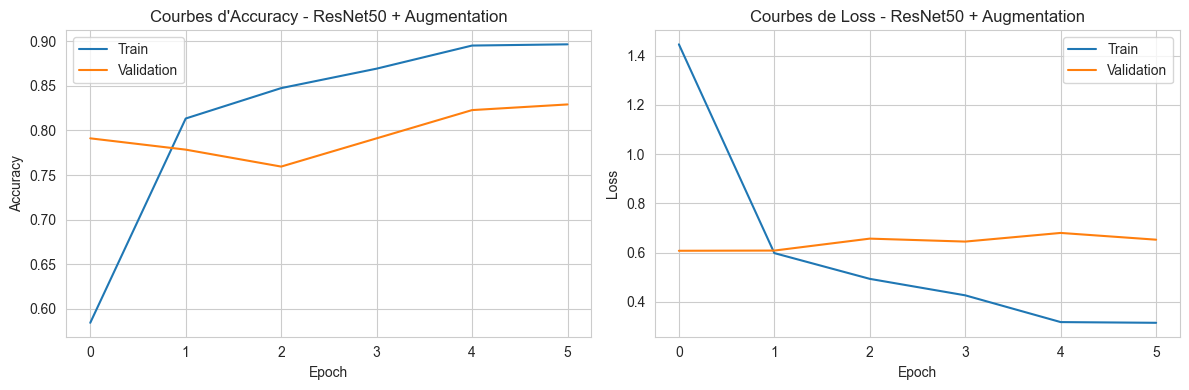

10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step


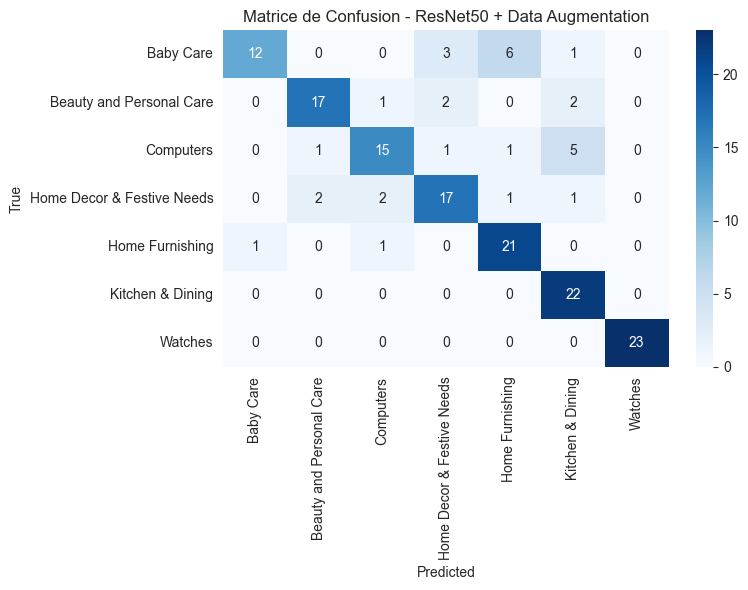

Classification Report ResNet50 + Augmentation
                            precision    recall  f1-score   support

                 Baby Care       0.92      0.55      0.69        22
  Beauty and Personal Care       0.85      0.77      0.81        22
                 Computers       0.79      0.65      0.71        23
Home Decor & Festive Needs       0.74      0.74      0.74        23
           Home Furnishing       0.72      0.91      0.81        23
          Kitchen & Dining       0.71      1.00      0.83        22
                   Watches       1.00      1.00      1.00        23

                  accuracy                           0.80       158
                 macro avg       0.82      0.80      0.80       158
              weighted avg       0.82      0.80      0.80       158


RÉSUMÉ - ResNet50 Transfer Learning + Data Augmentation
Test Accuracy: 0.8038
Test Loss: 0.5766
Temps d'entraînement: 905.80 secondes

Précision moyenne: 0.8192
Recall moyen: 0.8038
F1-score moyen: 0.79

In [44]:
# 1) Courbes d'accuracy et loss
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_resnet_aug.history['accuracy'], label='Train')
plt.plot(history_resnet_aug.history['val_accuracy'], label='Validation')
plt.title("Courbes d'Accuracy - ResNet50 + Augmentation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_resnet_aug.history['loss'], label='Train')
plt.plot(history_resnet_aug.history['val_loss'], label='Validation')
plt.title("Courbes de Loss - ResNet50 + Augmentation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


# 2) Matrice de confusion
# Générer les prédictions sur le test set
y_pred_probs_resnet_aug = resnet_aug_model.predict(resnet_test_gen)
y_pred_resnet_aug = np.argmax(y_pred_probs_resnet_aug, axis=1)
y_true_resnet_aug = resnet_test_gen.classes

# Noms des classes
class_names = list(resnet_test_gen.class_indices.keys())

# Matrice de confusion
cm_resnet_aug = confusion_matrix(y_true_resnet_aug, y_pred_resnet_aug)

plt.figure(figsize=(8,6))
sns.heatmap(cm_resnet_aug, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matrice de Confusion - ResNet50 + Data Augmentation")
plt.tight_layout()
plt.show()


# 3) Classification report
report_resnet_aug = classification_report(y_true_resnet_aug, y_pred_resnet_aug, target_names=class_names)
print("Classification Report ResNet50 + Augmentation")
print(report_resnet_aug)


# 4) Comparaison CNN vs ResNet50 Augmenté (optionnel)
# compare_confusion_matrices(cm, cm_resnet_aug, "CNN Custom", "ResNet50 + Augmentation", class_names)


# 5) Résumé des performances
print_model_summary("ResNet50 Transfer Learning + Data Augmentation", 
                   test_acc_resnet_aug, test_loss_resnet_aug, duration_resnet_aug,
                   y_true_resnet_aug, y_pred_resnet_aug, class_names)


#### COMPARAISON

In [45]:
# COMPARAISON DES MODÈLES DE CLASSIFICATION D'IMAGES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from math import pi

# 1) FONCTION POUR COLLECTER LES MÉTRIQUE
def get_model_metrics(model_name, test_acc, test_loss, duration, y_true, y_pred, class_names):
    """
    Extrait les métriques d'un modèle
    """
    report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    
    return {
        "Model": model_name,
        "Test Accuracy": test_acc,
        "Test Loss": test_loss,
        "Training Time (s)": duration,
        "Precision": report_dict['weighted avg']['precision'],
        "Recall": report_dict['weighted avg']['recall'],
        "F1-Score": report_dict['weighted avg']['f1-score']
    }

# 2) COLLECTE DES RÉSULTATS POUR CHAQUE MODÈLE
results_images = []

results_images.append(get_model_metrics(
    "VGG16", test_acc_vgg16, test_loss_vgg16, duration_vgg16,
    y_true_vgg16, y_pred_vgg16, class_names
))

results_images.append(get_model_metrics(
    "VGG16_aug", test_acc_vgg16_aug, test_loss_vgg16_aug, duration_vgg16_aug,
    y_true_vgg16_aug, y_pred_vgg16_aug, class_names
))

results_images.append(get_model_metrics(
     "CNN_base", test_acc, test_loss, duration_cnn_gray,
     y_true, y_pred, class_names
 ))

results_images.append(get_model_metrics(
     "CNN_base_aug", test_acc_cnn_aug, test_loss_cnn_aug, duration_cnn_aug,
     y_true_cnn_aug, y_pred_cnn_aug, class_names
 ))

results_images.append(get_model_metrics(
     "CNN_optimized", test_acc_cnn_opt, test_loss_cnn_opt, duration_cnn_optimized,
     y_true_cnn_otimized, y_pred_cnn_optimized, class_names
 ))

results_images.append(get_model_metrics(
     "CNN_optimized_aug", test_acc_cnn_opt_aug, test_loss_cnn_opt_aug, duration_cnn_opt_aug,
     y_true_cnn_opt_aug, y_pred_cnn_opt_aug, class_names
 ))

results_images.append(get_model_metrics(
    "MobileNetV2", test_acc_mobilenet, test_loss_mobilenet, duration_mobilenet,
    y_true_mobilenet, y_pred_mobilenet, class_names
))

results_images.append(get_model_metrics(
    "MobileNetV2_aug", test_acc_mobilenet_aug, test_loss_mobilenet_aug, duration_mobilenet_aug,
    y_true_mobilenet_aug, y_pred_mobilenet_aug, class_names
))

results_images.append(get_model_metrics(
    "ResNet50", test_acc_resnet, test_loss_resnet, duration_resnet,
    y_true_resnet, y_pred_resnet, class_names
))

results_images.append(get_model_metrics(
    "ResNet50_aug", test_acc_resnet_aug, test_loss_resnet_aug, duration_resnet_aug,
    y_true_resnet_aug, y_pred_resnet_aug, class_names
))

# 3) CRÉATION DU DATAFRAME DE COMPARAISON
df_comparison = pd.DataFrame(results_images)

# Tri par accuracy décroissante
df_comparison = df_comparison.sort_values(by='Test Accuracy', ascending=False)

print("COMPARAISON DES MODÈLES DE CLASSIFICATION D'IMAGES")
display(df_comparison.round(4))


# 7) ANALYSE DÉTAILLÉE
def analyze_models_performance(df):
    """Analyse détaillée des performances"""
    
    print("ANALYSE DÉTAILLÉE DES PERFORMANCES")
    
    
    # Meilleur modèle par métrique
    best_accuracy = df.loc[df['Test Accuracy'].idxmax()]
    best_precision = df.loc[df['Precision'].idxmax()]
    best_recall = df.loc[df['Recall'].idxmax()]
    best_f1 = df.loc[df['F1-Score'].idxmax()]
    fastest_training = df.loc[df['Training Time (s)'].idxmin()]
    lowest_loss = df.loc[df['Test Loss'].idxmin()]
    
    print(f"Meilleure Accuracy: {best_accuracy['Model']} ({best_accuracy['Test Accuracy']:.4f})")
    print(f"Meilleure Précision: {best_precision['Model']} ({best_precision['Precision']:.4f})")
    print(f"Meilleur Recall: {best_recall['Model']} ({best_recall['Recall']:.4f})")
    print(f"Meilleur F1-Score: {best_f1['Model']} ({best_f1['F1-Score']:.4f})")
    print(f"Plus rapide: {fastest_training['Model']} ({fastest_training['Training Time (s)']:.0f}s)")
    print(f"Perte la plus faible: {lowest_loss['Model']} ({lowest_loss['Test Loss']:.4f})")
    
    best_overall = df.loc[df['Precision'].idxmax()]
    print(f"\n MEILLEUR MODÈLE GLOBAL: {best_overall['Model']}")
    
    return df

df_final = analyze_models_performance(df_comparison)


COMPARAISON DES MODÈLES DE CLASSIFICATION D'IMAGES


Model  Test Accuracy  Test Loss  Training Time (s)  Precision  \
7    MobileNetV2_aug         0.8418     0.5067           509.9410     0.8408   
6        MobileNetV2         0.8354     0.5052           392.8636     0.8361   
8           ResNet50         0.8354     0.5409          1062.7235     0.8582   
9       ResNet50_aug         0.8038     0.5766           905.8020     0.8192   
0              VGG16         0.7468     0.7369          3444.3457     0.7477   
1          VGG16_aug         0.7215     0.7803          3631.6053     0.7477   
5  CNN_optimized_aug         0.5127     1.4459           435.5227     0.5310   
3       CNN_base_aug         0.5063     1.4578           831.4345     0.5077   
4      CNN_optimized         0.4494     1.7016           354.6702     0.4647   
2           CNN_base         0.3861     1.6364           351.9196     0.4246   

   Recall  F1-Score  
7  0.8418    0.8382  
6  0.8354    0.8329  
8  0.8354    0.8346  
9  0.8038    0.7985  
0  0.7468    0.7461  
1  0.7468    0.7461  
5  0.5127    0.5076  
3  0.5063    0.4933  
4  0.4494    0.4509  
2  0.3861    0.3593

ANALYSE DÉTAILLÉE DES PERFORMANCES
Meilleure Accuracy: MobileNetV2_aug (0.8418)
Meilleure Précision: ResNet50 (0.8582)
Meilleur Recall: MobileNetV2_aug (0.8418)
Meilleur F1-Score: MobileNetV2_aug (0.8382)
Plus rapide: CNN_base (352s)
Perte la plus faible: MobileNetV2 (0.5052)

 MEILLEUR MODÈLE GLOBAL: ResNet50
